In [1]:
import scipy
import sys

sys.path.append("./src/")
import pycvxcluster.pycvxcluster
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from pycvxcluster.algos.michael import *
from tqdm import tqdm
import pandas as pd
import time

# Testing (nothing useful here)

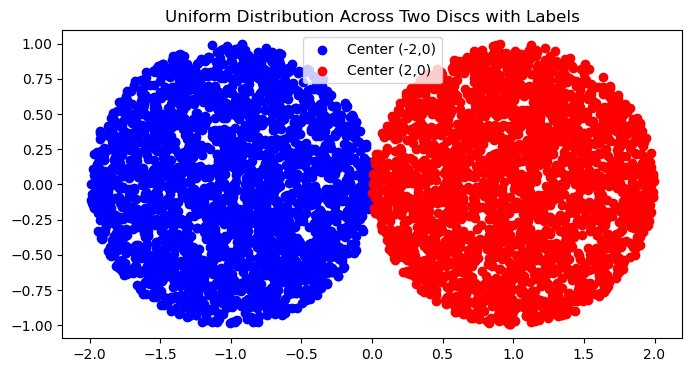

((5000, 2), (5000,))

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def generate_disc_samples(centers, radius, num_samples):
    # Generating angles and radii
    angles = np.random.uniform(0, 2 * np.pi, num_samples)
    radii = np.sqrt(np.random.uniform(0, 1, num_samples)) * radius

    # Randomly assigning discs
    disc_indices = np.random.randint(0, len(centers), num_samples)
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)

    # Adjusting coordinates based on the center of each disc
    for i, center in enumerate(centers):
        mask = disc_indices == i
        x[mask] += center[0]
        y[mask] += center[1]

    # Creating X and y arrays
    X = np.vstack((x, y)).T  # Combine x and y coordinates into a single array
    y = disc_indices  # Labels indicating the center of each point

    return X, y

# Parameters
num_samples = 5000
radius = 1
centers = [(-1, 0), (1, 0)]
centers_array = np.array(centers)

# Generate samples and centroids
X, y = generate_disc_samples(centers, radius, num_samples)

# Plotting the points with labels
plt.figure(figsize=(8, 4))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='Center (-2,0)')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Center (2,0)')
plt.axis('equal')
plt.title('Uniform Distribution Across Two Discs with Labels')
plt.legend()
plt.show()
X.shape, y.shape


In [4]:
import scipy.linalg as la
from pycvxcluster.algos.michael import compute_weight_matrix
gamma = X.shape[0]**(2/(3*X.shape[1]))
weight_matrix, _ = compute_weight_matrix(X.T, gamma=gamma, omega=0.2)

Computing weight matrix...
Weight matrix computed in 1.2539986670017242 seconds.


In [5]:
#get X row 1 and 2
Xt = X.T
X0 = X[[0],:]
X1 = X[[1],:]
X0, X1

(array([[-0.89269475,  0.49948977]]), array([[0.25226738, 0.10968948]]))

In [6]:
test = gamma**(X.shape[1]+1) / np.exp(gamma * la.norm(X0 - X1))
test

5.210100019701579e-06

In [7]:
weight_matrix[0,1]

0.0

/Users/michaelthomas/Desktop/Semester 4/math466/project/pycvxcluster-main/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


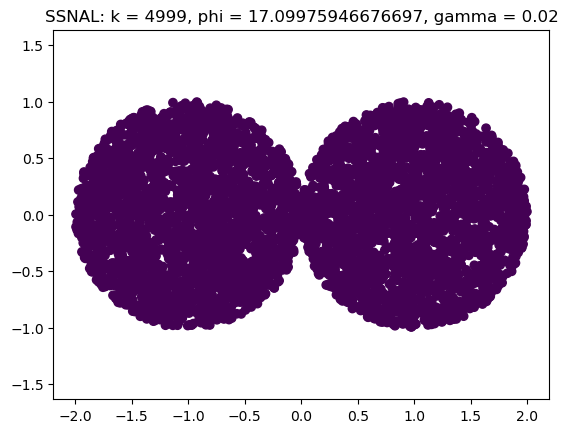

In [8]:
ssnal = pycvxcluster.pycvxcluster.SSNAL(k=X.shape[0]-1, phi=gamma, gamma=0.02)

ssnal.fit(X=X, save_labels=True, weight_matrix=weight_matrix,save_centers=True)

plt.scatter(X[:, 0], X[:, 1], c=ssnal.labels_)  # Use all samples and proper feature indexing

plt.title(f"SSNAL: k = {ssnal.k}, phi = {ssnal.phi}, gamma = {ssnal.gamma}")  # Title of the plot
plt.axis('equal')  # Equal aspect ratio

plt.show()

In [9]:
X.shape, y.shape

((5000, 2), (5000,))

In [10]:
ssnal_labels = ssnal.labels_ - 1
ssnal_labels[:10], y[:10]

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([0, 1, 1, 1, 1, 0, 0, 0, 0, 0]))

In [11]:
pred = ssnal.labels_ - 1
y_array = np.array(y)
mse_clusters(X, y, pred, centers_array)

0.9999953463073449

In [12]:
Xt = np.array([[10,0,0],[0,0,0]])
yt = np.array([1,1])
predt = np.array([0,1])
centers_arrayt = np.array([[10,0,0],[0,0,0]])


mse_clusters(Xt, yt, predt, centers_arrayt)

50.0

In [13]:
N, d = X.shape
N**(-1/(8*d))
2*4*0.002*(gamma**(-1/3))

0.006210453515770285

In [14]:
N, d, d_prime = 10000, 2, 4/3
#gamma*N**(-1/max(d,2))*(np.log(N))**(1/d_prime)+(1+lambd)*gamma**(-1/3)

# Start here

## make shapes

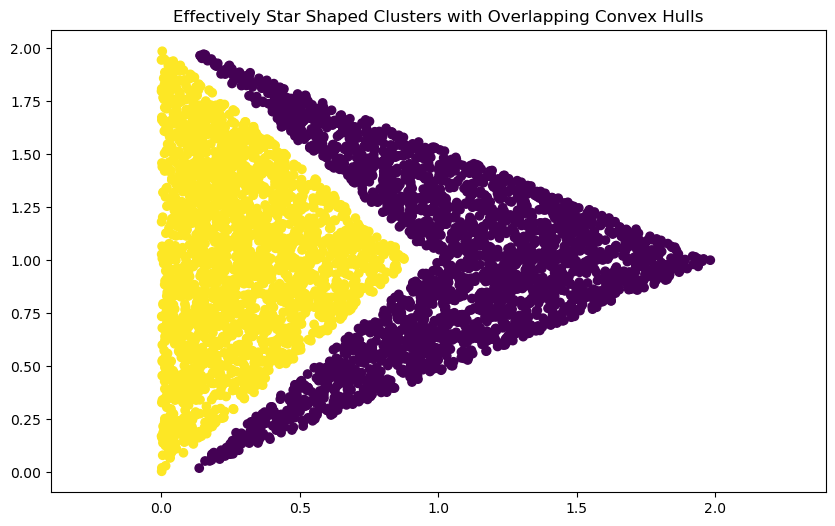

((4745, 2), (4745,))

In [52]:
# two star shaped polygons with overlapping convex hulls
import matplotlib.path as mplPath

# Define the vertices of the polygons (clusters)
vertices1 = np.array([[0.1,0], [1,1], [0.1,2], [2,1]])
vertices2 = np.array([[0,0], [0,2], [.9,1]])

# Define paths for the two clusters
path1 = mplPath.Path(vertices1)
path2 = mplPath.Path(vertices2)

# Determine the overall bounding box
min_x = min(vertices1[:,0].min(), vertices2[:,0].min())
max_x = max(vertices1[:,0].max(), vertices2[:,0].max())
min_y = min(vertices1[:,1].min(), vertices2[:,1].min())
max_y = max(vertices1[:,1].max(), vertices2[:,1].max())

# Generate a set of random points within the bounding box that contains both clusters
n_points = 10000  # number of random points to start with
#X_random = np.random.rand(n_points, 2) * np.array([2, 2])  # scale and translate points

random_x = np.random.uniform(min_x, max_x, n_points)
random_y = np.random.uniform(min_y, max_y, n_points)
X_random = np.column_stack((random_x, random_y))

# Check which points are inside each cluster
inside_cluster1 = path1.contains_points(X_random)
inside_cluster2 = path2.contains_points(X_random)

# Filter points to only those within the clusters and create the labels vector
X_inside_cluster1 = X_random[inside_cluster1, :]
X_inside_cluster2 = X_random[inside_cluster2, :]
X_poly = np.vstack((X_inside_cluster1, X_inside_cluster2))
y_poly = np.hstack((np.zeros(X_inside_cluster1.shape[0], dtype=int), np.ones(X_inside_cluster2.shape[0], dtype=int)))

# Calculate the means of each cluster
mean_cluster1 = np.mean(X_poly[y_poly == 0], axis=0)
mean_cluster2 = np.mean(X_poly[y_poly == 1], axis=0)

# Store the means in an np array
centers_poly = np.array([mean_cluster1, mean_cluster2])

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_poly[:, 0], X_poly[:, 1], c=y_poly)
plt.title('Effectively Star Shaped Clusters with Overlapping Convex Hulls')
plt.xlim(-0.4, 2.4)
plt.show()

# Return the shape of X and y to confirm the sizes
X_poly.shape, y_poly.shape


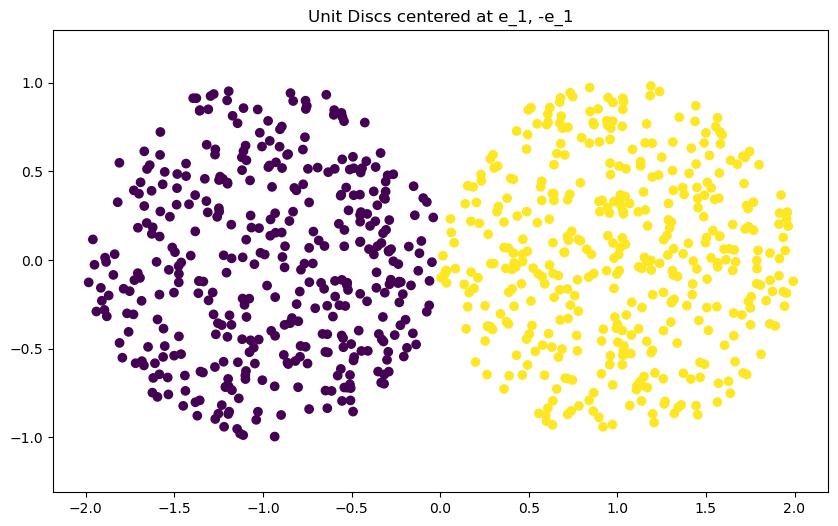

In [82]:
# Function to generate random points within a circle
def generate_circle_samples(center, radius, num_samples):
    # Generate random angles
    angles = np.random.uniform(0, 2 * np.pi, num_samples)
    # Generate random radii
    radii = np.sqrt(np.random.uniform(0, radius**2, num_samples))
    # Convert polar coordinates to Cartesian coordinates
    x = center[0] + radii * np.cos(angles)
    y = center[1] + radii * np.sin(angles)
    return np.column_stack((x, y))

# Number of points to generate
N=800
random_assignment = np.random.randint(0, 2, N+1)
num_samples1 = len(random_assignment[random_assignment == 0])
num_samples2 = len(random_assignment[random_assignment == 1])


# Generate samples for each circle
circle1_samples = generate_circle_samples(center=(-1, 0), radius=1, num_samples=num_samples1)
circle2_samples = generate_circle_samples(center=(1, 0), radius=1, num_samples=num_samples2)

# Combine the samples and assign labels
X_disc = np.vstack((circle1_samples, circle2_samples))
y_disc = np.hstack((np.zeros(num_samples1, dtype=int), np.ones(num_samples2, dtype=int)))

# Store the means in an np array
centers_disc = np.array([(-1,0), (1,0)])

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_disc[:, 0], X_disc[:, 1], c=y_disc)
plt.title('Unit Discs centered at e_1, -e_1')
plt.axis('equal')
plt.show()

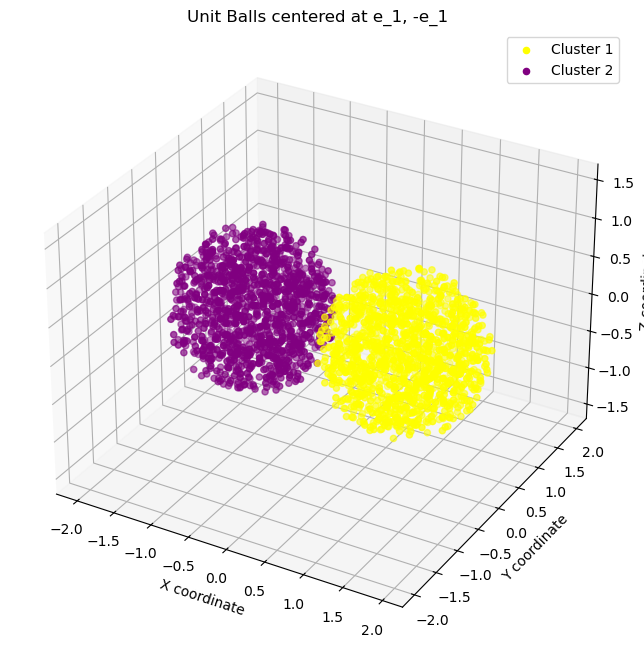

In [17]:
def unit_balls(N, d):
    def generate_points_in_cube(d, num_samples):
        # Generate random points in a d-dimensional cube
        points = np.random.uniform(-1, 1, (num_samples, d))
        return points

    def points_in_unit_ball(points):
        # Calculate the squared distance from the origin for each point
        squared_distances = np.sum(points**2, axis=1)
        # A point is in the unit ball if its squared distance from the origin is less than or equal to 1
        mask = squared_distances <= 1
        return points[mask]

    # Define the number of dimensions and the number of points to sample
    random_assignment = np.random.randint(0, 2, N)
    num_samples1 = len(random_assignment[random_assignment == 0])
    num_samples2 = len(random_assignment[random_assignment == 1])

    # Generate random points in a d-dimensional cube
    e1 = np.zeros(d)
    e1[0] = 1
    cluster1 = generate_points_in_cube(d, num_samples1)
    cluster2 = generate_points_in_cube(d, num_samples2) 

    cluster1 = points_in_unit_ball(cluster1) + e1
    cluster2 = points_in_unit_ball(cluster2) - e1

    # Combine the samples and assign labels
    X = np.vstack((cluster1, cluster2))
    y = np.hstack((np.zeros(len(cluster1), dtype=int), np.ones(len(cluster2),  dtype=int)))

    # Store the means in an np array
    centers = np.array([e1, -e1])
    return X, y, centers, d

X_ball, y_ball, centers_ball, d = unit_balls(5000, 3)

if d == 3:
    # Plotting in 3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_ball[y_ball == 0][:, 0], X_ball[y_ball == 0][:, 1], X_ball[y_ball == 0][:, 2], c='yellow', label='Cluster 1')
    ax.scatter(X_ball[y_ball == 1][:, 0], X_ball[y_ball == 1][:, 1], X_ball[y_ball == 1][:, 2], c='purple', label='Cluster 2')
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_zlabel('Z coordinate')
    ax.set_title('Unit Balls centered at e_1, -e_1')
    plt.axis('equal')
    plt.legend()
    plt.show()

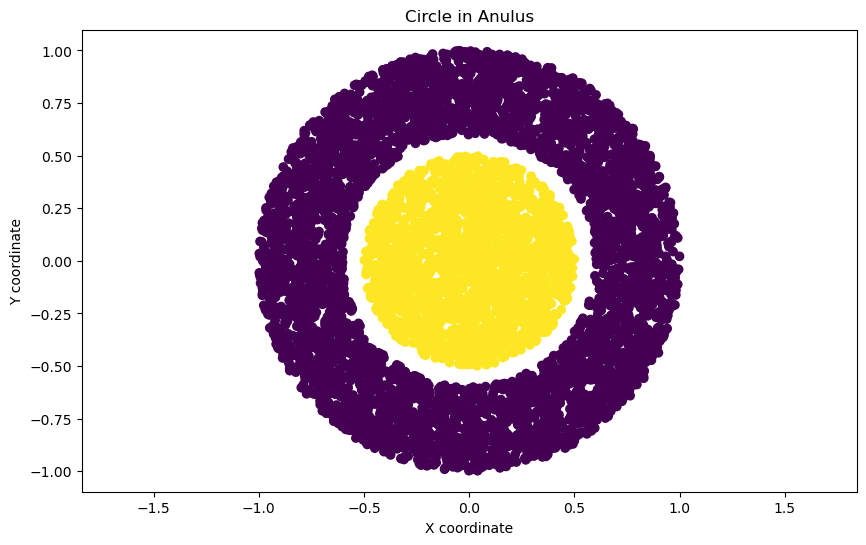

In [113]:
# make circle in anulus
def points_in_anulus(points, inner_radius, outer_radius):
        # Calculate the squared distance from the origin for each point
        squared_distances = np.sum(points**2, axis=1)
        # A point is in the unit ball if its squared distance from the origin is less than or equal to 1
        mask = (squared_distances >= inner_radius**2) & (squared_distances <= outer_radius**2)
        return points[mask]

def generate_points_in_cube(d, num_samples):
        # Generate random points in a d-dimensional cube
        points = np.random.uniform(-1, 1, (num_samples, d))
        return points


points_in_square = generate_points_in_cube(2, 10000)
cluster1 = points_in_anulus(points_in_square, 0.6, 1)
cluster2 = points_in_anulus(points_in_square, 0, 0.5)

# Combine the samples and assign labels
X_anulus = np.vstack((cluster1, cluster2))
y_anulus = np.hstack((np.zeros(len(cluster1), dtype=int), np.ones(len(cluster2), dtype=int)))
centers_anulus = np.array([[0,0], [0,0]])

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_anulus[:, 0], X_anulus[:, 1], c=y_anulus)
plt.title('Circle in Anulus')
plt.axis('equal')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.show()

## SON on each shape

### circles

In [165]:
N, d = X_disc.shape
gamma = N**(3/(4*d))
gamma = 1.1914519767709479
weight_matrix, _ = compute_weight_matrix(X_disc.T, gamma=gamma, omega=None)

lambd = 0.005
ssnal = pycvxcluster.pycvxcluster.SSNAL(k=X_disc.shape[0]-1, phi=gamma, gamma=lambd, maxiter=2000)
ssnal.fit(X=X_disc, save_labels=True, weight_matrix=weight_matrix,save_centers=True)

Computing weight matrix...
Weight matrix computed in 1.762459791265428 seconds.


/Users/michaelthomas/Desktop/Semester 4/math466/Weighted SON Project/pycvxcluster-main/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


SSNAL(gamma=0.005, k=800, maxiter=2000, phi=1.191451976770948)

In [166]:
pred = np.array(ssnal.labels_) - 1
y_array = np.array(y_disc)
mse = mse_clusters(X_disc, y_array, pred, centers_disc)
mse

0.49212793543281236

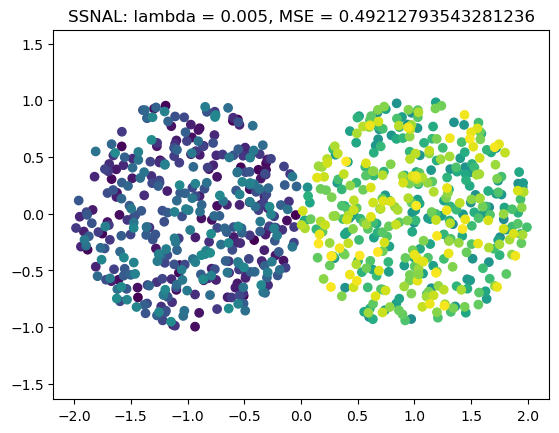

In [167]:
plt.scatter(X_disc[:, 0], X_disc[:, 1], c=pred)

plt.title(f"SSNAL: lambda = {lambd}, MSE = {mse}")  # Title of the plot
plt.axis('equal')  # Equal aspect ratio

plt.show()

In [51]:
print(f"C: {mse/centroid_bound(X_disc, gamma, lambd)}")

C: 0.00034696726803509146


### polygons

In [91]:
N, d = X_poly.shape
gamma = N**(3/(4*d))*9
weight_matrix, _ = compute_weight_matrix(X_poly.T, gamma=gamma, omega=0.2)

lambd = 10
ssnal = pycvxcluster.pycvxcluster.SSNAL(k=X_poly.shape[0]-1, phi=gamma, gamma=lambd, maxiter=2000)
ssnal.fit(X=X_poly, save_labels=True, weight_matrix=weight_matrix,save_centers=True)

Computing weight matrix...
Weight matrix computed in 3.4182884572073817 seconds.


SSNAL(gamma=10, k=4746, maxiter=2000, phi=215.2284714456001)

In [94]:
pred = np.array(ssnal.labels_) - 1
mse = mse_clusters(X_poly, y_poly, pred, centers_poly)
mse, pred.max()

(0.0, 1)

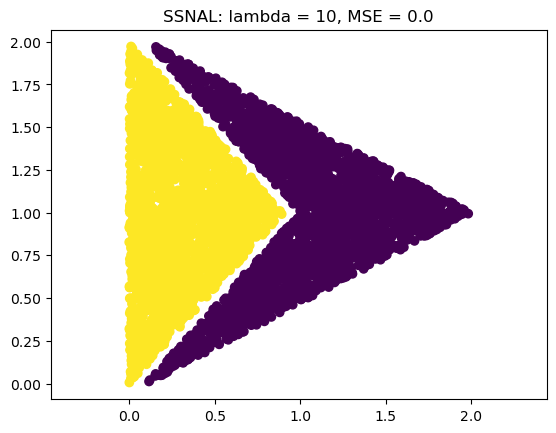

In [95]:
plt.scatter(X_poly[:, 0], X_poly[:, 1], c=pred)

plt.title(f"SSNAL: lambda = {lambd}, MSE = {mse}")  # Title of the plot
plt.axis('equal')  # Equal aspect ratio

plt.show()

In [26]:
X_polyt = np.zeros((100, 2), dtype=int)

centroid_bound(X_polyt, gamma, lambd)

4.202448396345407

In [27]:
X_ball.shape

(2538, 3)

### d-balls

In [28]:
N, d = X_ball.shape
gamma = N**(3/(4*d))
weight_matrix, _ = compute_weight_matrix(X_ball.T, gamma=gamma, omega=1)

lambd = 0.0005
ssnal = pycvxcluster.pycvxcluster.SSNAL(k=X_ball.shape[0]-1, phi=gamma, gamma=lambd, maxiter=2000)
ssnal.fit(X=X_ball, save_labels=True, weight_matrix=weight_matrix,save_centers=True)

Computing weight matrix...
Weight matrix computed in 4.459818082861602 seconds.


SSNAL(gamma=0.0005, k=2537, maxiter=2000, phi=7.097786054203099)

In [29]:
pred = np.array(ssnal.labels_) - 1
mse = mse_clusters(X_ball, y_ball, pred, centers_ball)
mse, pred.max()

(0.0063028404449698375, 4)

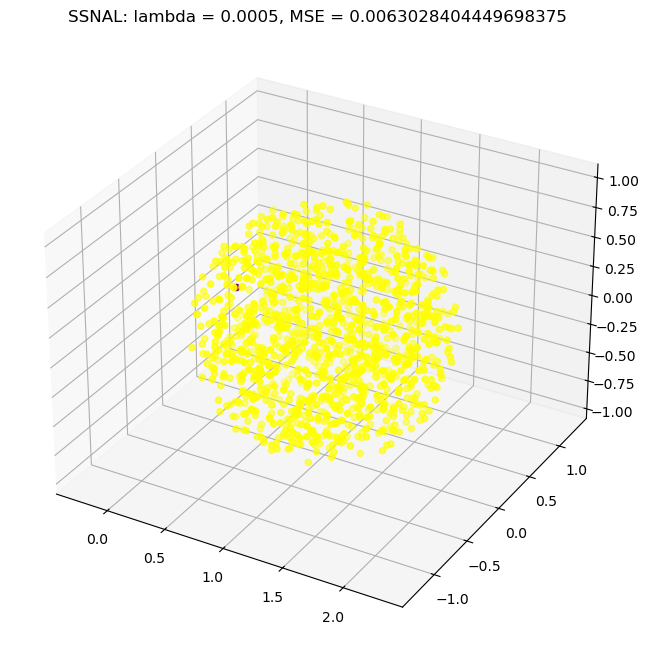

In [30]:
# Plotting in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_ball[pred == 0][:, 0], X_ball[pred == 0][:, 1], X_ball[pred == 0][:, 2], c='yellow')
ax.scatter(X_ball[pred == 1][:, 0], X_ball[pred == 1][:, 1], X_ball[pred == 1][:, 2], c='purple')
ax.set_title(f"SSNAL: lambda = {lambd}, MSE = {mse}")
plt.axis('equal')
plt.show()

In [31]:
centroid_bound(X_ball, gamma, lambd)

1.5542758050425451

### Circle in Anulus

In [135]:
N, d = X_anulus.shape
gamma = N**(3/(4*d))*10
weight_matrix, _ = compute_weight_matrix(X_anulus.T, gamma=gamma, omega=0.18)

lambd = 1000
ssnal = pycvxcluster.pycvxcluster.SSNAL(k=X_anulus.shape[0]-1, phi=gamma, gamma=lambd, maxiter=2000)
ssnal.fit(X=X_anulus, save_labels=True, weight_matrix=weight_matrix,save_centers=True)

Computing weight matrix...
Weight matrix computed in 7.714439874514937 seconds.


SSNAL(gamma=1000, k=6988, maxiter=2000, phi=276.474855773134)

In [136]:
pred = np.array(ssnal.labels_) - 1
mse = mse_clusters(X_anulus, y_anulus, pred, centers_anulus)
mse, pred.max()

(0.00020950655499350892, 1)

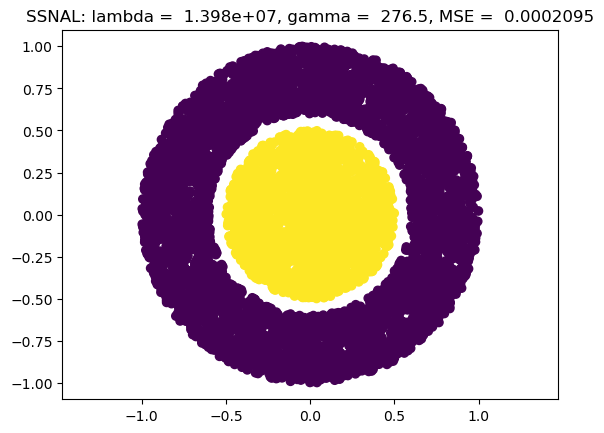

In [137]:
plt.scatter(X_anulus[:, 0], X_anulus[:, 1], c=pred)

plt.title(f"SSNAL: lambda = {lambd*2*N: .4g}, gamma = {gamma: .4g}, MSE = {mse: .4g}")  # Title of the plot
plt.axis('equal')  # Equal aspect ratio

plt.show()

In [112]:
centroid_bound(X_anulus, gamma, lambd)

8.681535851401703

In [36]:
N, d, d_prime = 10000000000, 2, 4/3
gamma = N**(3/(4*d))
gamma*N**(-1/max(d,2))*(np.log(N))**(1/d_prime)+(1+lambd)*gamma**(-1/3)

0.7035693636520876

## K-means on each shape

### circles

In [37]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2).fit(X_disc)
y_pred = kmeans.predict(X_disc)

/Users/michaelthomas/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


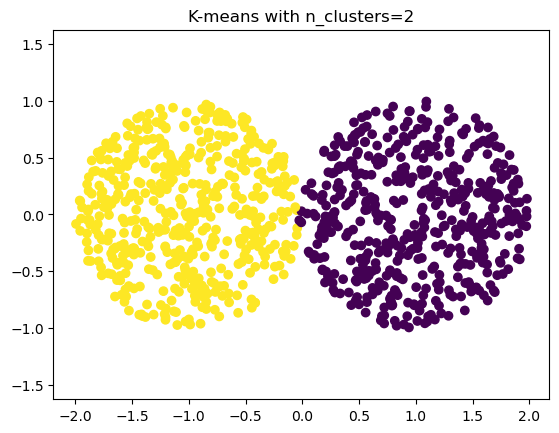

In [38]:
plt.scatter(X_disc[:, 0], X_disc[:, 1], c=y_pred)

plt.title(f"K-means with n_clusters=2")  # Title of the plot
plt.axis('equal')  # Equal aspect ratio

plt.show()

### polygons

In [39]:
kmeans = KMeans(n_clusters=2, init='random', ).fit(X_poly)
y_pred = kmeans.predict(X_poly)

/Users/michaelthomas/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


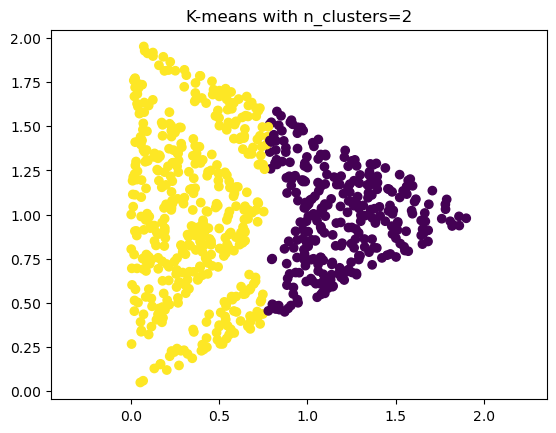

In [40]:
plt.scatter(X_poly[:, 0], X_poly[:, 1], c=y_pred)

plt.title(f"K-means with n_clusters=2")  # Title of the plot
plt.axis('equal')  # Equal aspect ratio

plt.show()

In [41]:
y_pred = kmeans.predict(X_poly)
mse_clusters(X_poly, y_poly, y_pred, centers=centers_poly)

0.09529850952510285

### d-balls

In [42]:
kmeans = KMeans(n_clusters=2, init='random', ).fit(X_ball)
y_pred = kmeans.predict(X_ball)

/Users/michaelthomas/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


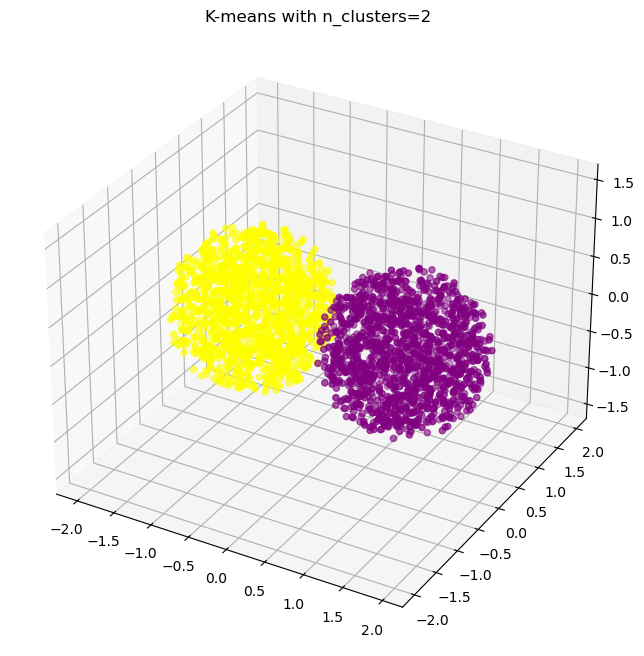

In [43]:
# Plotting in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_ball[y_pred == 0][:, 0], X_ball[y_pred == 0][:, 1], X_ball[y_pred == 0][:, 2], c='yellow')
ax.scatter(X_ball[y_pred == 1][:, 0], X_ball[y_pred == 1][:, 1], X_ball[y_pred == 1][:, 2], c='purple')
ax.set_title(f"K-means with n_clusters=2")
plt.axis('equal')
plt.show()

In [44]:
centroid_bound(X_ball, gamma, lambd)

819.0650946972888

### Circle in Anulus

In [45]:
kmeans = KMeans(n_clusters=4, init='random', ).fit(X_anulus)
y_pred = kmeans.predict(X_anulus)

/Users/michaelthomas/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


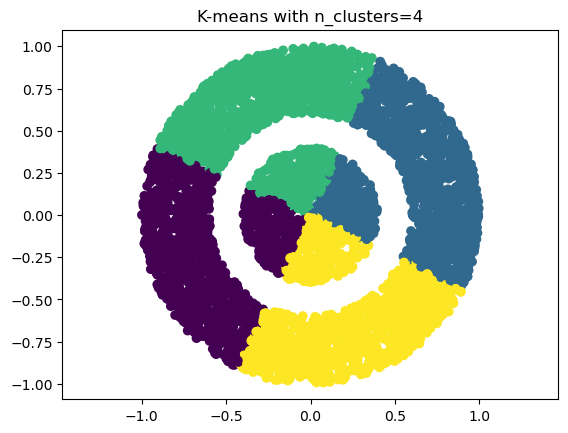

In [63]:
plt.scatter(X_anulus[:, 0], X_anulus[:, 1], c=y_pred)

plt.title(f"K-means with n_clusters=4")  # Title of the plot
plt.axis('equal')  # Equal aspect ratio

plt.show()

In [47]:
centroid_bound(X_anulus, gamma, lambd)

395.40465538239704

In [48]:
N, d, d_prime = 10000000000, 2, 4/3
gamma = N**(3/(4*d))
gamma*N**(-1/max(d,2))*(np.log(N))**(1/d_prime)+(1+lambd)*gamma**(-1/3)

0.7035693636520876

## Unweighted SON on each shape

### circles

In [49]:
N, d = X_disc.shape
gamma = 1
weight_matrix = np.ones((X_disc.shape[0], X_disc.shape[0]))
for i in range(X_disc.shape[0]):
    weight_matrix[i,i] = 0

lambd = 0.003
ssnal = pycvxcluster.pycvxcluster.SSNAL(k=X_disc.shape[0]-1, phi=gamma, gamma=lambd, maxiter=2000)
ssnal.fit(X=X_disc, save_labels=True, weight_matrix=weight_matrix,save_centers=True)

/Users/michaelthomas/Desktop/Semester 4/math466/project/pycvxcluster-main/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/michaelthomas/Desktop/Semester 4/math466/project/pycvxcluster-main/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


SSNAL(gamma=0.003, k=1000, maxiter=2000, phi=1)

In [50]:
pred = np.array(ssnal.labels_) - 1
y_array = np.array(y_disc)
mse = mse_clusters(X_disc, y_array, pred, centers_disc)
mse, pred.max()

(1.0002794362990826, 0)

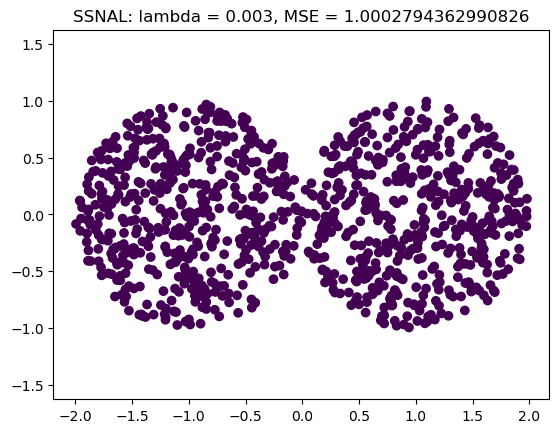

In [51]:
plt.scatter(X_disc[:, 0], X_disc[:, 1], c=pred)

plt.title(f"SSNAL: lambda = {lambd}, MSE = {mse}")  # Title of the plot
plt.axis('equal')  # Equal aspect ratio

plt.show()

### polygons

In [52]:
N, d = X_poly.shape
gamma = 1
weight_matrix = np.ones((X_poly.shape[0], X_poly.shape[0]))
for i in range(X_poly.shape[0]):
    weight_matrix[i,i] = 0

lambd = 0.001
ssnal = pycvxcluster.pycvxcluster.SSNAL(k=X_poly.shape[0]-1, phi=gamma, gamma=lambd, maxiter=2000)
ssnal.fit(X=X_poly, save_labels=True, weight_matrix=weight_matrix,save_centers=True)

SSNAL(gamma=0.001, k=750, maxiter=2000, phi=1)

In [53]:
pred = np.array(ssnal.labels_) - 1
mse = mse_clusters(X_poly, y_poly, pred, centers_poly)
mse

0.2597252709058

In [54]:
X_poly.shape, y_poly.shape, pred.shape, centers_poly.shape
y_poly[0:10], pred.max()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 749)

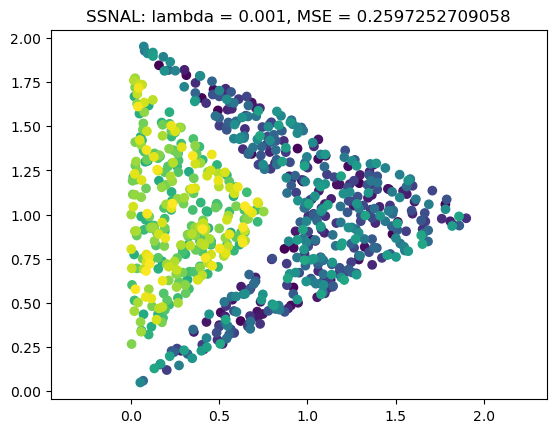

In [55]:
plt.scatter(X_poly[:, 0], X_poly[:, 1], c=pred)

plt.title(f"SSNAL: lambda = {lambd}, MSE = {mse}")  # Title of the plot
plt.axis('equal')  # Equal aspect ratio

plt.show()

In [56]:
X_polyt = np.zeros((100, 2), dtype=int)

centroid_bound(X_polyt, gamma, lambd)

1.3153650547438605

In [57]:
X_ball.shape

(2538, 3)

### d-balls

In [58]:
N, d = X_ball.shape
gamma = N**(3/(4*d))
weight_matrix, _ = compute_weight_matrix(X_ball.T, gamma=gamma, omega=1)

lambd = 0.0005
ssnal = pycvxcluster.pycvxcluster.SSNAL(k=X_ball.shape[0]-1, phi=gamma, gamma=lambd, maxiter=2000)
ssnal.fit(X=X_ball, save_labels=True, weight_matrix=weight_matrix,save_centers=True)

Computing weight matrix...
Weight matrix computed in 4.233437875285745 seconds.


SSNAL(gamma=0.0005, k=2537, maxiter=2000, phi=7.097786054203099)

In [59]:
pred = np.array(ssnal.labels_) - 1
mse = mse_clusters(X_ball, y_ball, pred, centers_ball)
mse, pred.max()

(0.0063028404449698375, 4)

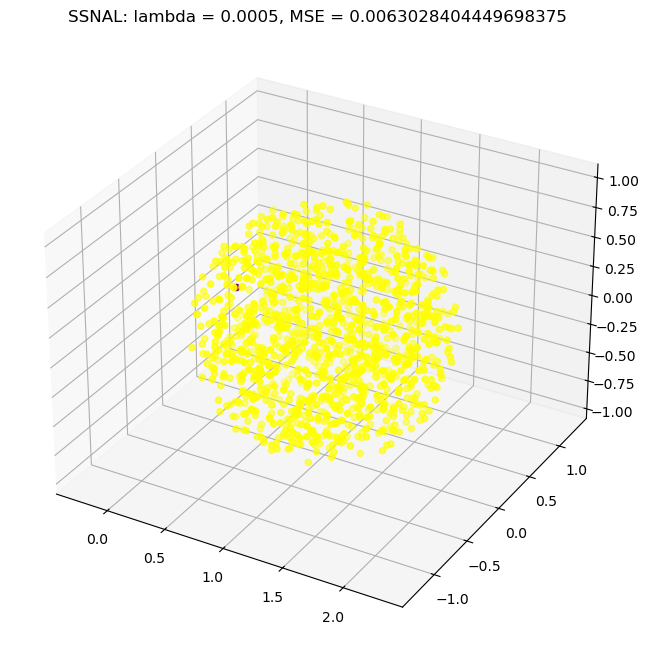

In [60]:
# Plotting in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_ball[pred == 0][:, 0], X_ball[pred == 0][:, 1], X_ball[pred == 0][:, 2], c='yellow')
ax.scatter(X_ball[pred == 1][:, 0], X_ball[pred == 1][:, 1], X_ball[pred == 1][:, 2], c='purple')
ax.set_title(f"SSNAL: lambda = {lambd}, MSE = {mse}")
plt.axis('equal')
plt.show()

In [61]:
centroid_bound(X_ball, gamma, lambd)

1.5542758050425451

### Circle in Anulus

In [62]:
N, d = X_anulus.shape
gamma = N**(3/(4*d))
weight_matrix, _ = compute_weight_matrix(X_anulus.T, gamma=gamma, omega=1)

lambd = 0.0006
ssnal = pycvxcluster.pycvxcluster.SSNAL(k=X_anulus.shape[0]-1, phi=gamma, gamma=lambd, maxiter=2000)
ssnal.fit(X=X_anulus, save_labels=True, weight_matrix=weight_matrix,save_centers=True)

Computing weight matrix...


KeyboardInterrupt: 

In [ ]:
pred = np.array(ssnal.labels_) - 1
mse = mse_clusters(X_anulus, y_anulus, pred, centers_anulus)
mse, pred.max()

(0.39524041840759416, 4)

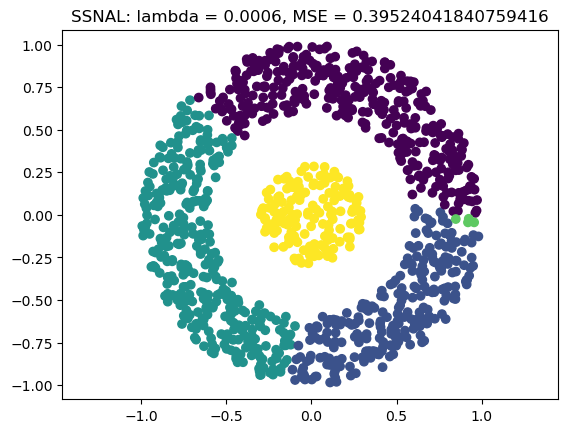

In [ ]:
plt.scatter(X_anulus[:, 0], X_anulus[:, 1], c=pred)

plt.title(f"SSNAL: lambda = {lambd}, MSE = {mse}")  # Title of the plot
plt.axis('equal')  # Equal aspect ratio

plt.show()

In [ ]:
centroid_bound(X_anulus, gamma, lambd)

2.209381276739618

In [ ]:
N, d, d_prime = 10000000000, 2, 4/3
gamma = N**(3/(4*d))
gamma*N**(-1/max(d,2))*(np.log(N))**(1/d_prime)+(1+lambd)*gamma**(-1/3)

0.647368971612564

# Looking at parameter choice

## optimal gamma for (1.5)

In [190]:
from sympy import symbols, diff, solve, log, oo

#for d geq 3
# Define the variables
C, gamma, N, d, d_prime, lambd = symbols('C gamma N d d_prime lambda')

# Define the function f(gamma)
f_gamma = C * (gamma * N**(-1/d) * (log(N))**(1/d) + (1 + lambd) * gamma**(-1/3))

# Differentiate f(gamma) with respect to gamma
f_prime = diff(f_gamma, gamma)

# Solve f'(gamma) = 0 for gamma
gamma_critical_points = solve(f_prime, gamma)
gamma_critical_points[3]

0.438691337650831*(N**(1/d)*(lambda + 1.0)/log(N)**(1/d))**(3/4)

In [22]:
f_gamma

C*((lambda + 1)/gamma**0.333333333333333 + gamma*log(N)**(1/d)/N**(1/d))

In [191]:
# for d=2

f_gamma_d2 = C * (gamma * N**(-1/2) * (log(N))**(3/4) + (1 + lambd) * gamma**(-1/3))

# Differentiate f(gamma) with respect to gamma
f_prime_d2 = diff(f_gamma_d2, gamma)
f_double_prime_d2 = diff(f_prime_d2, gamma)

# Solve f'(gamma) = 0 for gamma
gamma_critical_points_d2 = solve(f_prime_d2, gamma)
gamma_critical_points_d2[3]

0.438691337650831*(N**0.5*(lambda + 1.0)/log(N)**0.75)**(3/4)

In [193]:
f_gamma_d2

C*(gamma*log(N)**0.75/N**0.5 + (lambda + 1)/gamma**0.333333333333333)

In [192]:
f_double_prime_d2

0.444444444444444*C*(lambda + 1)/gamma**2.33333333333333

In [186]:
0.438691337650831*(800**0.5*(lambd*2*800 + 1.0)/log(800)**0.75)**(3/4)

1361.15565271555*(lambda + 0.000625)**0.75/log(800)**0.5625

In [27]:
f_gamma_d2

C*(gamma*log(N)**0.75/N**0.5 + (lambda + 1)/gamma**0.333333333333333)

In [34]:
# for d=1

f_gamma_d1 = C * (gamma * N**(-1/2) * (log(N))**(1/oo) + (1 + lambd) * gamma**(-1/3))

# Differentiate f(gamma) with respect to gamma
f_prime_d1 = diff(f_gamma_d1, gamma)

# Solve f'(gamma) = 0 for gamma
gamma_critical_points_d1 = solve(f_prime_d1, gamma)
gamma_critical_points_d1[3]

0.438691337650831*(N**0.5*(lambda + 1.0))**(3/4)

In [35]:
f_gamma_d1

C*(gamma/N**0.5 + (lambda + 1)/gamma**0.333333333333333)

In [4]:
from fractions import Fraction

# Convert the decimal to a fraction with limited denominator size
fraction_approximation = Fraction(0.438691337650831).limit_denominator(1000)

fraction_approximation

Fraction(161, 367)

# clean shapes

## balls

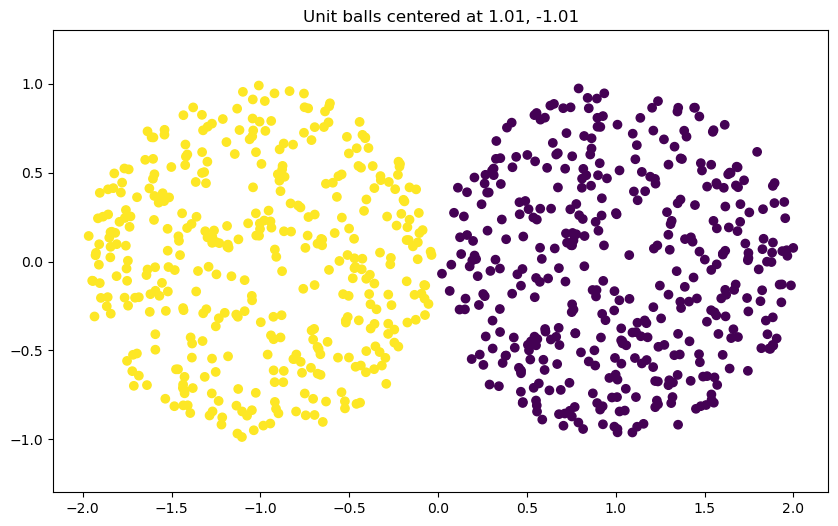

(806, 2)

In [261]:
def unit_balls(N, d):
    def generate_points_in_cube(d, num_samples):
        # Generate random points in a d-dimensional cube
        points = np.random.uniform(-1, 1, (num_samples, d))
        return points

    def points_in_unit_ball(points):
        # Calculate the squared distance from the origin for each point
        squared_distances = np.sum(points**2, axis=1)
        # A point is in the unit ball if its squared distance from the origin is less than or equal to 1
        mask = squared_distances <= 1
        return points[mask]

    # Define the number of dimensions and the number of points to sample
    random_assignment = np.random.randint(0, 2, N)
    num_samples1 = len(random_assignment[random_assignment == 0])
    num_samples2 = len(random_assignment[random_assignment == 1])

    e1 = np.zeros(d)
    e1[0] = 1.01
    cluster1 = generate_points_in_cube(d, num_samples1)
    cluster2 = generate_points_in_cube(d, num_samples2) 

    cluster1 = points_in_unit_ball(cluster1) + e1
    cluster2 = points_in_unit_ball(cluster2) - e1

    # Combine the samples and assign labels
    X = np.vstack((cluster1, cluster2))
    y = np.hstack((np.zeros(len(cluster1), dtype=int), np.ones(len(cluster2),  dtype=int)))

    # Store the means in an np array
    centers = np.array([e1, -e1])
    return X, y, centers, d

X_ball, y_ball, centers_ball, d = unit_balls(1020, 2)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_ball[:, 0], X_ball[:, 1], c=y_ball)
plt.title('Unit balls centered at 1.01, -1.01')
plt.axis('equal')
plt.show()
X_ball.shape

## polygons 1

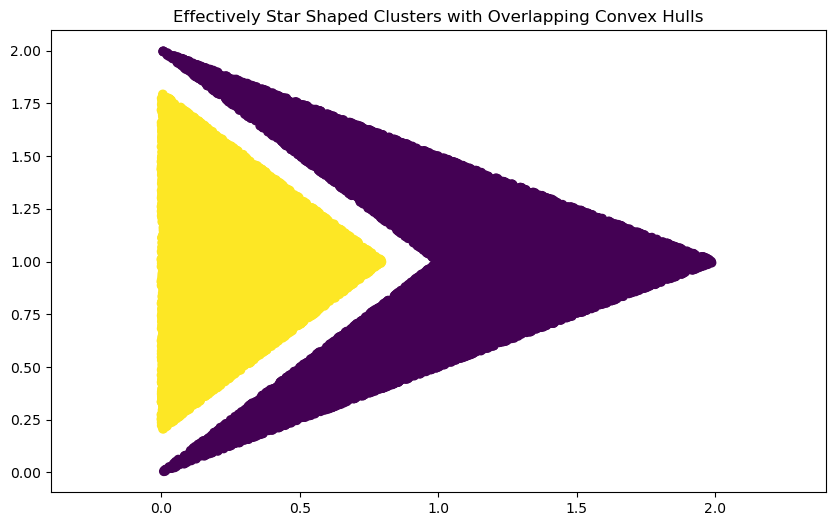

((41151, 2), (41151,))

In [344]:
# two star shaped polygons with overlapping convex hulls
import matplotlib.path as mplPath

# Define the vertices of the polygons (clusters)
vertices1 = np.array([[0,0], [1,1], [0,2], [2,1]])
vertices2 = np.array([[0,0.2], [0,1.8], [.8,1]])

# Define paths for the two clusters
path1 = mplPath.Path(vertices1)
path2 = mplPath.Path(vertices2)

# Determine the overall bounding box
min_x = min(vertices1[:,0].min(), vertices2[:,0].min())
max_x = max(vertices1[:,0].max(), vertices2[:,0].max())
min_y = min(vertices1[:,1].min(), vertices2[:,1].min())
max_y = max(vertices1[:,1].max(), vertices2[:,1].max())

# Generate a set of random points within the bounding box that contains both clusters
n_points = 100000  # number of random points to start with
#X_random = np.random.rand(n_points, 2) * np.array([2, 2])  # scale and translate points

random_x = np.random.uniform(min_x, max_x, n_points)
random_y = np.random.uniform(min_y, max_y, n_points)
X_random = np.column_stack((random_x, random_y))

# Check which points are inside each cluster
inside_cluster1 = path1.contains_points(X_random)
inside_cluster2 = path2.contains_points(X_random)

# Filter points to only those within the clusters and create the labels vector
X_inside_cluster1 = X_random[inside_cluster1, :]
X_inside_cluster2 = X_random[inside_cluster2, :]
X_poly = np.vstack((X_inside_cluster1, X_inside_cluster2))
y_poly = np.hstack((np.zeros(X_inside_cluster1.shape[0], dtype=int), np.ones(X_inside_cluster2.shape[0], dtype=int)))

# Calculate the means of each cluster
mean_cluster1 = np.mean(X_poly[y_poly == 0], axis=0)
mean_cluster2 = np.mean(X_poly[y_poly == 1], axis=0)

# Store the means in an np array
centers_poly = np.array([mean_cluster1, mean_cluster2])

centers_poly1 = centers_poly
X_poly1 = X_poly
y_poly1 = y_poly

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_poly1[:, 0], X_poly1[:, 1], c=y_poly1)
plt.title('Effectively Star Shaped Clusters with Overlapping Convex Hulls')
plt.xlim(-0.4, 2.4)
plt.show()

# Return the shape of X and y to confirm the sizes
X_poly1.shape, y_poly1.shape


## Polygons 2

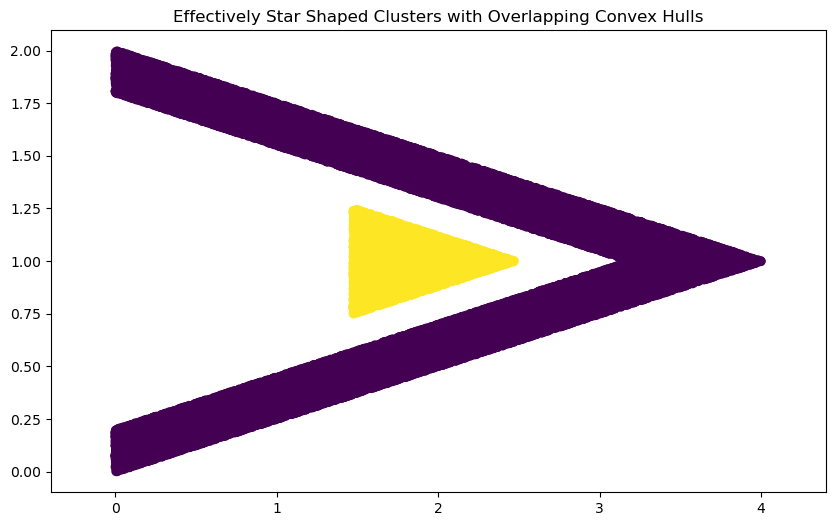

((63019, 2), (63019,))

In [6]:
# two star shaped polygons with overlapping convex hulls
import matplotlib.path as mplPath

# Define the vertices of the polygons (clusters)
vertices1 = np.array([[0,0], [4,1], [0,2], [0,1.8], [3.2,1], [0,0.2]])
vertices2 = np.array([[1.47407407, 0.75],[1.47407407, 1.25],[2.47407407, 1]])

# Define paths for the two clusters
path1 = mplPath.Path(vertices1)
path2 = mplPath.Path(vertices2)

# Determine the overall bounding box
min_x = 0
max_x = 4
min_y = 0
max_y = 2

# Generate a set of random points within the bounding box that contains both clusters
n_points = 300000  # number of random points to start with
X_random = np.random.rand(n_points, 2) * np.array([2, 2])  # scale and translate points

random_x = np.random.uniform(min_x, max_x, n_points)
random_y = np.random.uniform(min_y, max_y, n_points)
X_random = np.column_stack((random_x, random_y))

# Check which points are inside each cluster
inside_cluster1 = path1.contains_points(X_random)
inside_cluster2 = path2.contains_points(X_random)

# Filter points to only those within the clusters and create the labels vector
X_inside_cluster1 = X_random[inside_cluster1, :]
X_inside_cluster2 = X_random[inside_cluster2, :]
X_poly = np.vstack((X_inside_cluster1, X_inside_cluster2))
y_poly = np.hstack((np.zeros(X_inside_cluster1.shape[0], dtype=int), np.ones(X_inside_cluster2.shape[0], dtype=int)))

# Calculate the means of each cluster
mean_cluster1 = np.mean(X_poly[y_poly == 0], axis=0)
mean_cluster2 = np.mean(X_poly[y_poly == 1], axis=0)

# Store the means in an np array
centers_poly = np.array([mean_cluster1, mean_cluster2])
# center 1 is 1.80740741, 1

centers_poly2 = centers_poly
X_poly2 = X_poly
y_poly2 = y_poly

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_poly2[:, 0], X_poly2[:, 1], c=y_poly2)
plt.title('Effectively Star Shaped Clusters with Overlapping Convex Hulls')
plt.xlim(-0.4, 4.4)
plt.show()

# Return the shape of X and y to confirm the sizes
X_poly2.shape, y_poly2.shape


# Choosing parameters

## mse on balls for grid of lambd, gamma

In [237]:
# accurate gamma lambda correspondence

N = X_ball.shape[0]

lambdas = np.array([i for i in range(1, 52, 5)]) / (2 * N)
lambdas

gammas = 0.438691337650831 * (N**0.5 * (lambdas*2*N + 1.0) / np.log(N)**0.75)**(3/4)
mse_results = np.empty(len(lambdas), dtype=float)
predictions = np.empty((len(lambdas), N), dtype=int)

for i, (lambd, gamma) in tqdm(enumerate(zip(lambdas, gammas)), total=len(lambdas)):
    weight_matrix, _ = compute_weight_matrix(X_ball.T, gamma=gamma, omega=None, verbose=0)
    ssnal = pycvxcluster.pycvxcluster.SSNAL(k=X_ball.shape[0]-1, phi=gamma, gamma=lambd, maxiter=2000, verbose=0)
    ssnal.fit(X=X_ball, save_labels=True, weight_matrix=weight_matrix,save_centers=True)
    pred = np.array(ssnal.labels_) - 1
    mse = mse_clusters(X_ball, y_ball, pred, centers_ball)
    mse_results[i] = mse
    # Store the predictions in row i
    predictions[i, :] = pred

  0%|          | 0/11 [00:00<?, ?it/s]/Users/michaelthomas/Desktop/Semester 4/math466/Weighted SON Project/pycvxcluster-main/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
100%|██████████| 11/11 [04:32<00:00, 24.74s/it]


In [238]:
# Assuming mse_results, lambdas, and gammas are already defined and calculated
data = {
    'Lambda': lambdas * 2 * N,
    'Gamma': gammas,
    'MSE': mse_results
}

# Create a DataFrame from the data dictionary
results_df = pd.DataFrame(data)

# Display the DataFrame
print(results_df)

    Lambda      Gamma       MSE
0      1.0   3.108028  0.504860
1      6.0   7.953092  0.000677
2     11.0  11.915119  0.000677
3     16.0  15.472096  0.256881
4     21.0  18.772818  0.000677
5     26.0  21.889471  0.355559
6     31.0  24.864225  0.000677
7     36.0  27.724501  0.000677
8     41.0  30.489438  0.352659
9     46.0  33.173084  0.459974
10    51.0  35.786148  0.000677


In [149]:
# gamma half optimal
N = X_ball.shape[0]

lambdas = np.array([i for i in range(1, 52, 5)]) / (2 * N)
lambdas

gammas = (0.438691337650831 * (N**0.5 * (lambdas*2*N + 1.0) / np.log(N)**0.75)**(3/4))/2
mse_results_low = np.empty(len(lambdas), dtype=float)
predictions_low = np.empty((len(lambdas), N), dtype=int)

for i, (lambd, gamma) in tqdm(enumerate(zip(lambdas, gammas)), total=len(lambdas)):
    weight_matrix, _ = compute_weight_matrix(X_ball.T, gamma=gamma, omega=None, verbose=0)
    ssnal = pycvxcluster.pycvxcluster.SSNAL(k=X_ball.shape[0]-1, phi=gamma, gamma=lambd, maxiter=2000, verbose=0)
    ssnal.fit(X=X_ball, save_labels=True, weight_matrix=weight_matrix,save_centers=True)
    pred = np.array(ssnal.labels_) - 1
    mse = mse_clusters(X_ball, y_ball, pred, centers_ball)
    mse_results_low[i] = mse
    # Store the predictions in row i
    predictions_low[i, :] = pred

  0%|          | 0/11 [00:00<?, ?it/s]/Users/michaelthomas/Desktop/Semester 4/math466/Weighted SON Project/pycvxcluster-main/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
100%|██████████| 11/11 [02:58<00:00, 16.24s/it]


In [150]:
# gamma twice optimal
N = X_ball.shape[0]

lambdas = np.array([i for i in range(1, 52, 5)]) / (2 * N)
lambdas

gammas = (0.438691337650831 * (N**0.5 * (lambdas*2*N + 1.0) / np.log(N)**0.75)**(3/4))*2
mse_results_high = np.empty(len(lambdas), dtype=float)
predictions_high = np.empty((len(lambdas), N), dtype=int)

for i, (lambd, gamma) in tqdm(enumerate(zip(lambdas, gammas)), total=len(lambdas)):
    weight_matrix, _ = compute_weight_matrix(X_ball.T, gamma=gamma, omega=None, verbose=0)
    ssnal = pycvxcluster.pycvxcluster.SSNAL(k=X_ball.shape[0]-1, phi=gamma, gamma=lambd, maxiter=2000, verbose=0)
    ssnal.fit(X=X_ball, save_labels=True, weight_matrix=weight_matrix,save_centers=True)
    pred = np.array(ssnal.labels_) - 1
    mse = mse_clusters(X_ball, y_ball, pred, centers_ball)
    mse_results_high[i] = mse
    # Store the predictions in row i
    predictions_high[i, :] = pred

100%|██████████| 11/11 [09:04<00:00, 49.54s/it]


In [258]:
mse_results_tenth = [0.504862, 0.504862, 0.504861, 0.000677, 1.102945, 1.102945, 1.102945, 1.102945,
 1.102945, 1.102945, 1.102945]

data_original = {
    'Type': 'gamma',
    'Lambda': lambdas * 2 * N,
    'Gamma': gammas/2,
    'MSE': mse_results
}

data_low = {
    'Type': 'gamma/2',
    'Lambda': lambdas * 2 * N,
    'Gamma': gammas/4,
    'MSE': mse_results_low
}

data_high = {
    'Type': 'gamma*2',
    'Lambda': lambdas * 2 * N,
    'Gamma': gammas,
    'MSE': mse_results_high
}

data_tenth = {
    'Type': 'gamma/10',
    'Lambda': lambdas * 2 * N,
    'Gamma': gammas/10,
    'MSE': mse_results_tenth
}

# Convert each dictionary to a DataFrame
df_original = pd.DataFrame(data_original)
df_low = pd.DataFrame(data_low)
df_high = pd.DataFrame(data_high)
df_tenth = pd.DataFrame(data_tenth)

# Concatenate all DataFrames into one, vertically stacking them
results_df = pd.concat([df_high, df_original, df_low, df_tenth])

# Display the DataFrame
results_df

Type  Lambda     Gamma       MSE
0    gamma*2     1.0  1.848911  0.503093
1    gamma*2     6.0  1.853240  0.000677
2    gamma*2    11.0  1.857565  0.352644
3    gamma*2    16.0  1.861888  0.296720
4    gamma*2    21.0  1.866207  0.077546
5    gamma*2    26.0  1.870522  0.337053
6    gamma*2    31.0  1.874834  0.461735
7    gamma*2    36.0  1.879143  0.219003
8    gamma*2    41.0  1.883449  0.334985
9    gamma*2    46.0  1.887752  0.332488
10   gamma*2    51.0  1.892051  0.414448
0      gamma     1.0  0.924455  0.504860
1      gamma     6.0  0.926620  0.000677
2      gamma    11.0  0.928783  0.000677
3      gamma    16.0  0.930944  0.256881
4      gamma    21.0  0.933103  0.000677
5      gamma    26.0  0.935261  0.355559
6      gamma    31.0  0.937417  0.000677
7      gamma    36.0  0.939572  0.000677
8      gamma    41.0  0.941725  0.352659
9      gamma    46.0  0.943876  0.459974
10     gamma    51.0  0.946025  0.000677
0    gamma/2     1.0  0.462228  0.504862
1    gamma/2     6.0  0.463310  0.000677
2    gamma/2    11.0  0.464391  0.000677
3    gamma/2    16.0  0.465472  0.000677
4    gamma/2    21.0  0.466552  0.000677
5    gamma/2    26.0  0.467631  0.000677
6    gamma/2    31.0  0.468709  0.000677
7    gamma/2    36.0  0.469786  0.000677
8    gamma/2    41.0  0.470862  0.000677
9    gamma/2    46.0  0.471938  0.000677
10   gamma/2    51.0  0.473013  0.000677
0   gamma/10     1.0  0.184891  0.504862
1   gamma/10     6.0  0.185324  0.504862
2   gamma/10    11.0  0.185757  0.504861
3   gamma/10    16.0  0.186189  0.000677
4   gamma/10    21.0  0.186621  1.102945
5   gamma/10    26.0  0.187052  1.102945
6   gamma/10    31.0  0.187483  1.102945
7   gamma/10    36.0  0.187914  1.102945
8   gamma/10    41.0  0.188345  1.102945
9   gamma/10    46.0  0.188775  1.102945
10  gamma/10    51.0  0.189205  1.102945

In [260]:
# Pivot the DataFrame to the desired format
pivoted_df = results_df.pivot(index='Type', columns='Lambda', values='MSE')

# Display the pivoted DataFrame
pivoted_df = pivoted_df.round(4)
pivoted_df

Lambda      1.0     6.0     11.0    16.0    21.0    26.0    31.0    36.0  \
Type                                                                       
gamma     0.5049  0.0007  0.0007  0.2569  0.0007  0.3556  0.0007  0.0007   
gamma*2   0.5031  0.0007  0.3526  0.2967  0.0775  0.3371  0.4617  0.2190   
gamma/10  0.5049  0.5049  0.5049  0.0007  1.1029  1.1029  1.1029  1.1029   
gamma/2   0.5049  0.0007  0.0007  0.0007  0.0007  0.0007  0.0007  0.0007   

Lambda      41.0    46.0    51.0  
Type                              
gamma     0.3527  0.4600  0.0007  
gamma*2   0.3350  0.3325  0.4144  
gamma/10  1.1029  1.1029  1.1029  
gamma/2   0.0007  0.0007  0.0007

In [257]:
pivoted_df.to_csv('lambd_gamma_table.csv', index=True)

In [157]:
# gamma 10% optimal
N = X_ball.shape[0]

lambdas = np.array([i for i in range(1, 52, 5)]) / (2 * N)
lambdas

gammas = (0.438691337650831 * (N**0.5 * (lambdas*2*N + 1.0) / np.log(N)**0.75)**(3/4))/10
mse_results_tenth = np.empty(len(lambdas), dtype=float)
predictions_tenth = np.empty((len(lambdas), N), dtype=int)

for i, (lambd, gamma) in tqdm(enumerate(zip(lambdas, gammas)), total=len(lambdas)):
    weight_matrix, _ = compute_weight_matrix(X_ball.T, gamma=gamma, omega=None, verbose=0)
    ssnal = pycvxcluster.pycvxcluster.SSNAL(k=X_ball.shape[0]-1, phi=gamma, gamma=lambd, maxiter=2000, verbose=0)
    ssnal.fit(X=X_ball, save_labels=True, weight_matrix=weight_matrix,save_centers=True)
    pred = np.array(ssnal.labels_) - 1
    mse = mse_clusters(X_ball, y_ball, pred, centers_ball)
    mse_results_tenth[i] = mse
    # Store the predictions in row i
    predictions_tenth[i, :] = pred

  0%|          | 0/11 [00:00<?, ?it/s]/Users/michaelthomas/Desktop/Semester 4/math466/Weighted SON Project/pycvxcluster-main/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
 36%|███▋      | 4/11 [00:53<01:41, 14.54s/it]/Users/michaelthomas/Desktop/Semester 4/math466/Weighted SON Project/pycvxcluster-main/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
100%|██████████| 11/11 [02:29<00:00, 13.55s/it]


In [169]:
# Set numpy print options
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Assuming mse_results_tenth is a numpy array
print(mse_results_tenth)

[0.504862 0.504862 0.504861 0.000677 1.102945 1.102945 1.102945 1.102945
 1.102945 1.102945 1.102945]


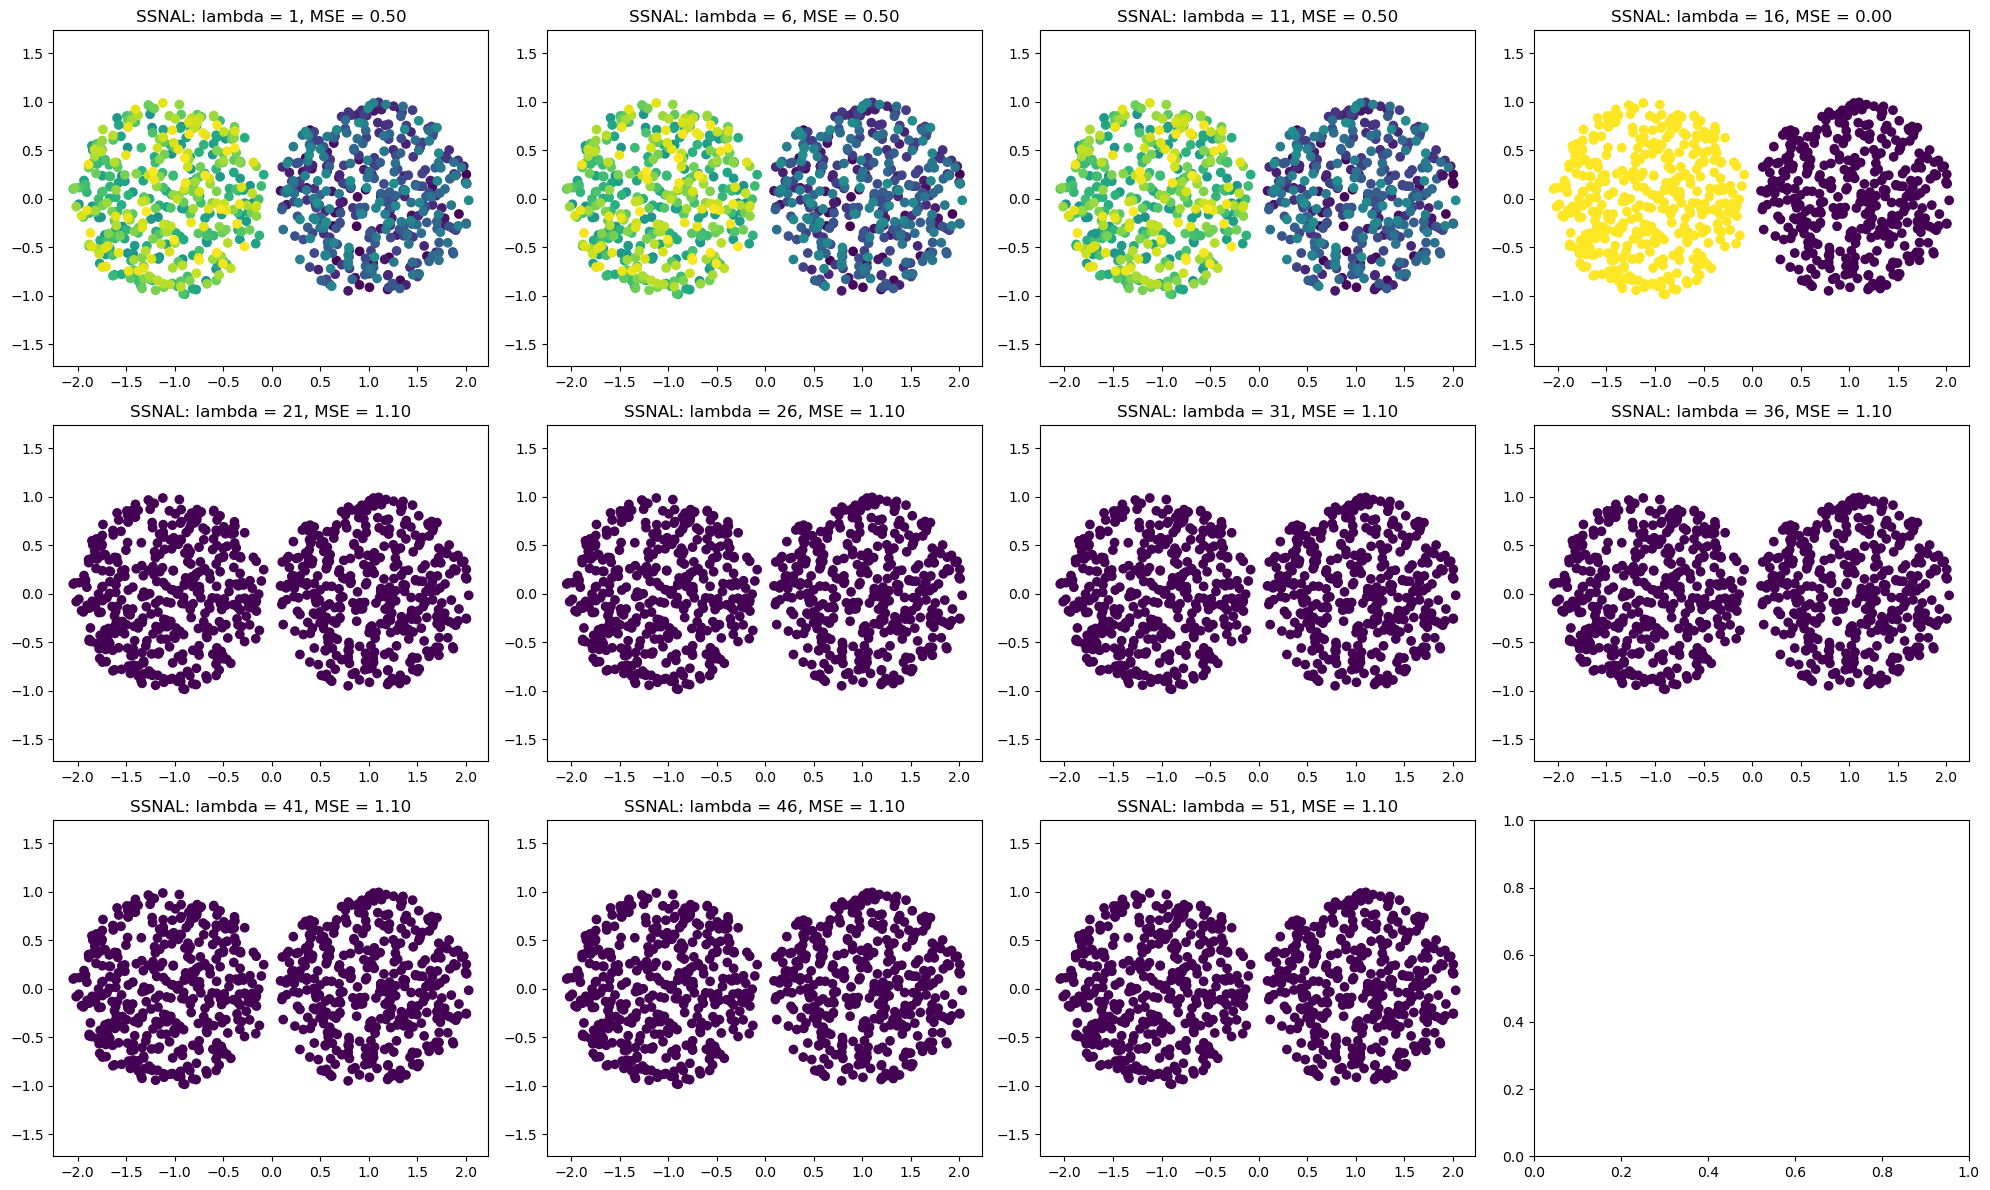

In [178]:
# Setting up the figure and axes for the subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 12))  # Adjust size as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop to create a scatter plot for each set of predictions
for i in range(11):
    ax = axes[i]
    sc = ax.scatter(X_ball[:, 0], X_ball[:, 1], c=predictions_tenth[i, :], cmap='viridis')
    ax.set_title(f"SSNAL: lambda = {lambdas[i]*2*N:.2g}, MSE = {mse_results_tenth[i]:.2f}")
    ax.axis('equal')

# Layout adjustment to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

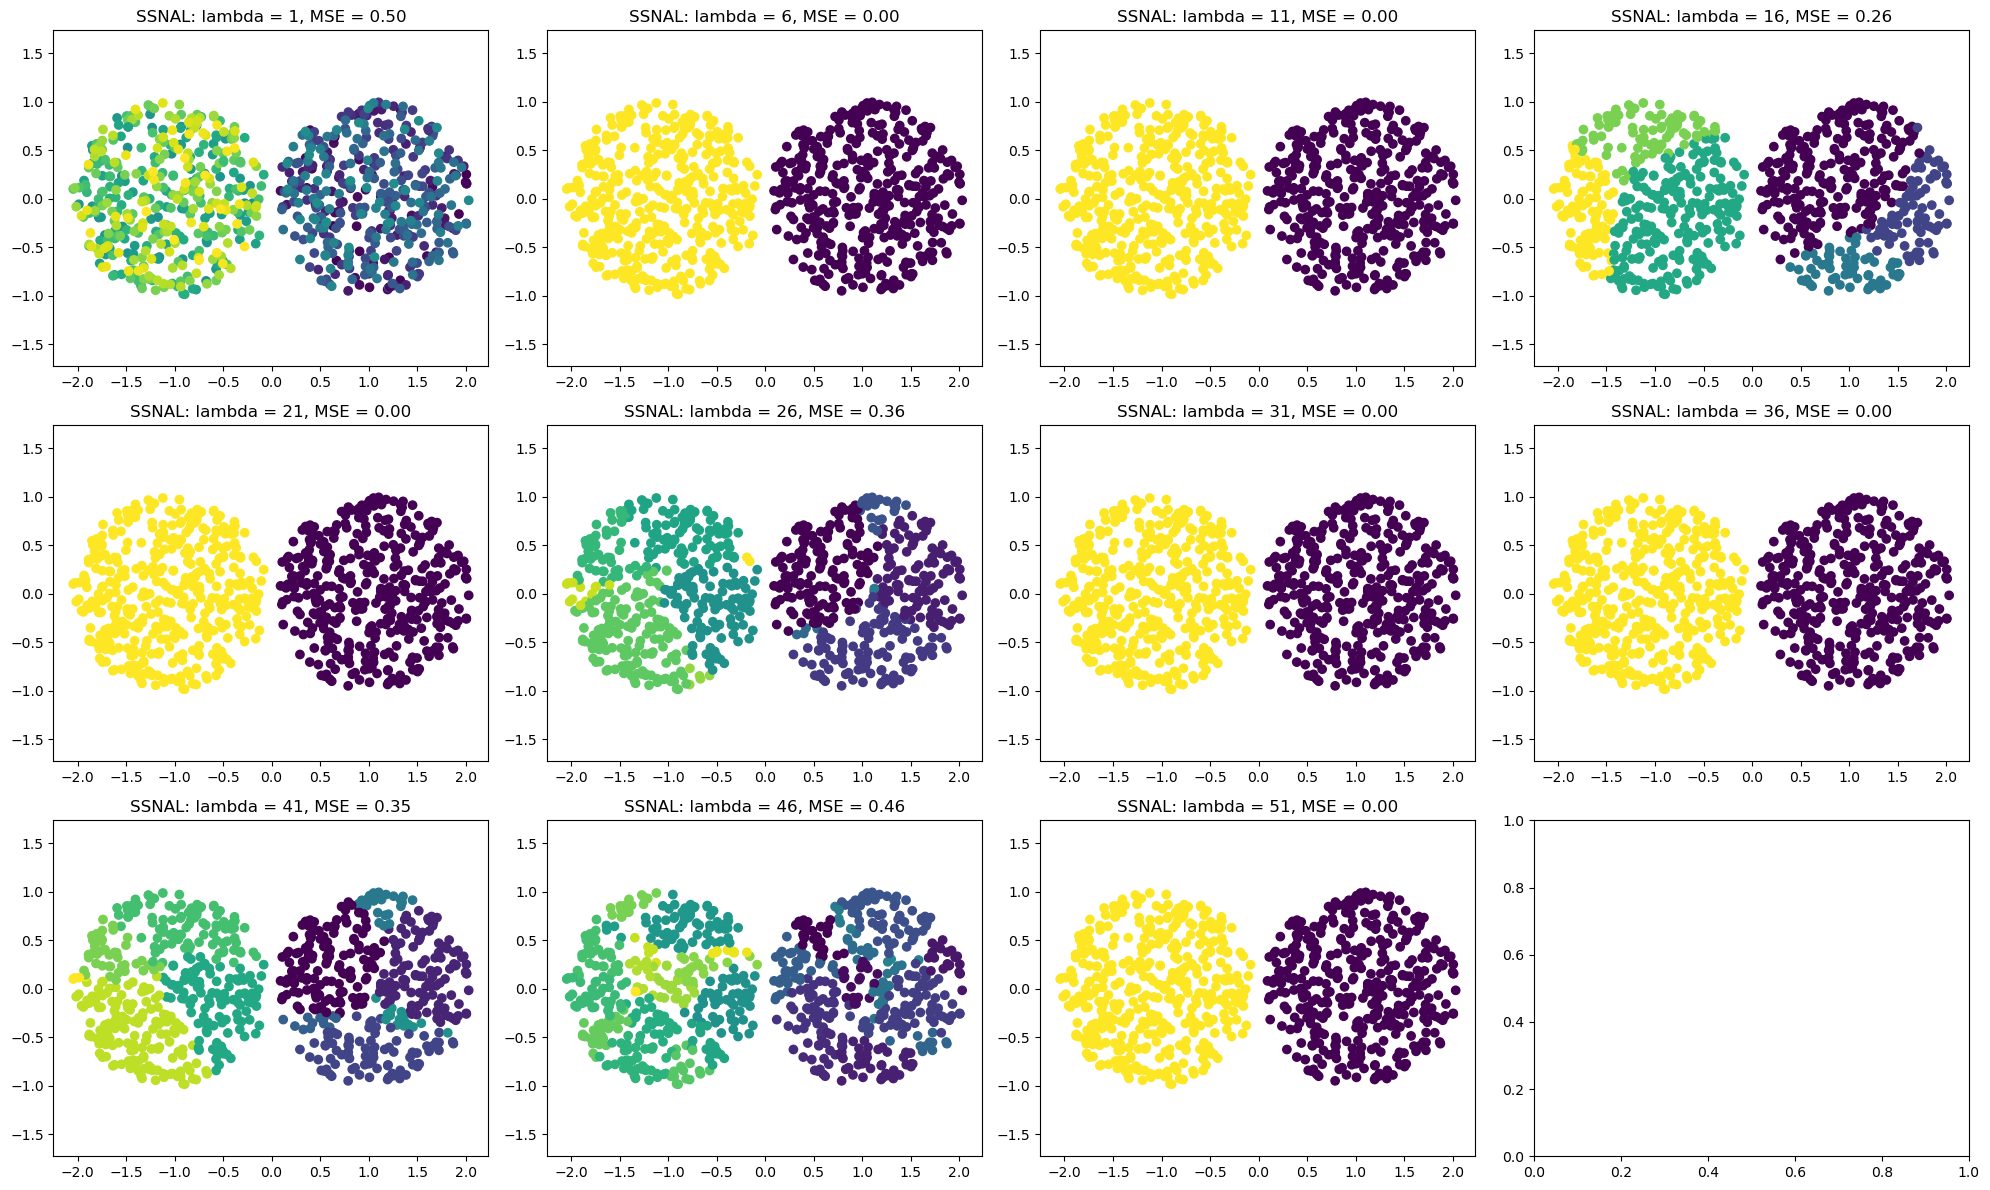

In [239]:
# Setting up the figure and axes for the subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 12))  # Adjust size as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop to create a scatter plot for each set of predictions
for i in range(11):
    ax = axes[i]
    sc = ax.scatter(X_ball[:, 0], X_ball[:, 1], c=predictions[i, :], cmap='viridis')
    ax.set_title(f"SSNAL: lambda = {lambdas[i]*2*N:.2g}, MSE = {mse_results[i]:.2f}")
    ax.axis('equal')

# Layout adjustment to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

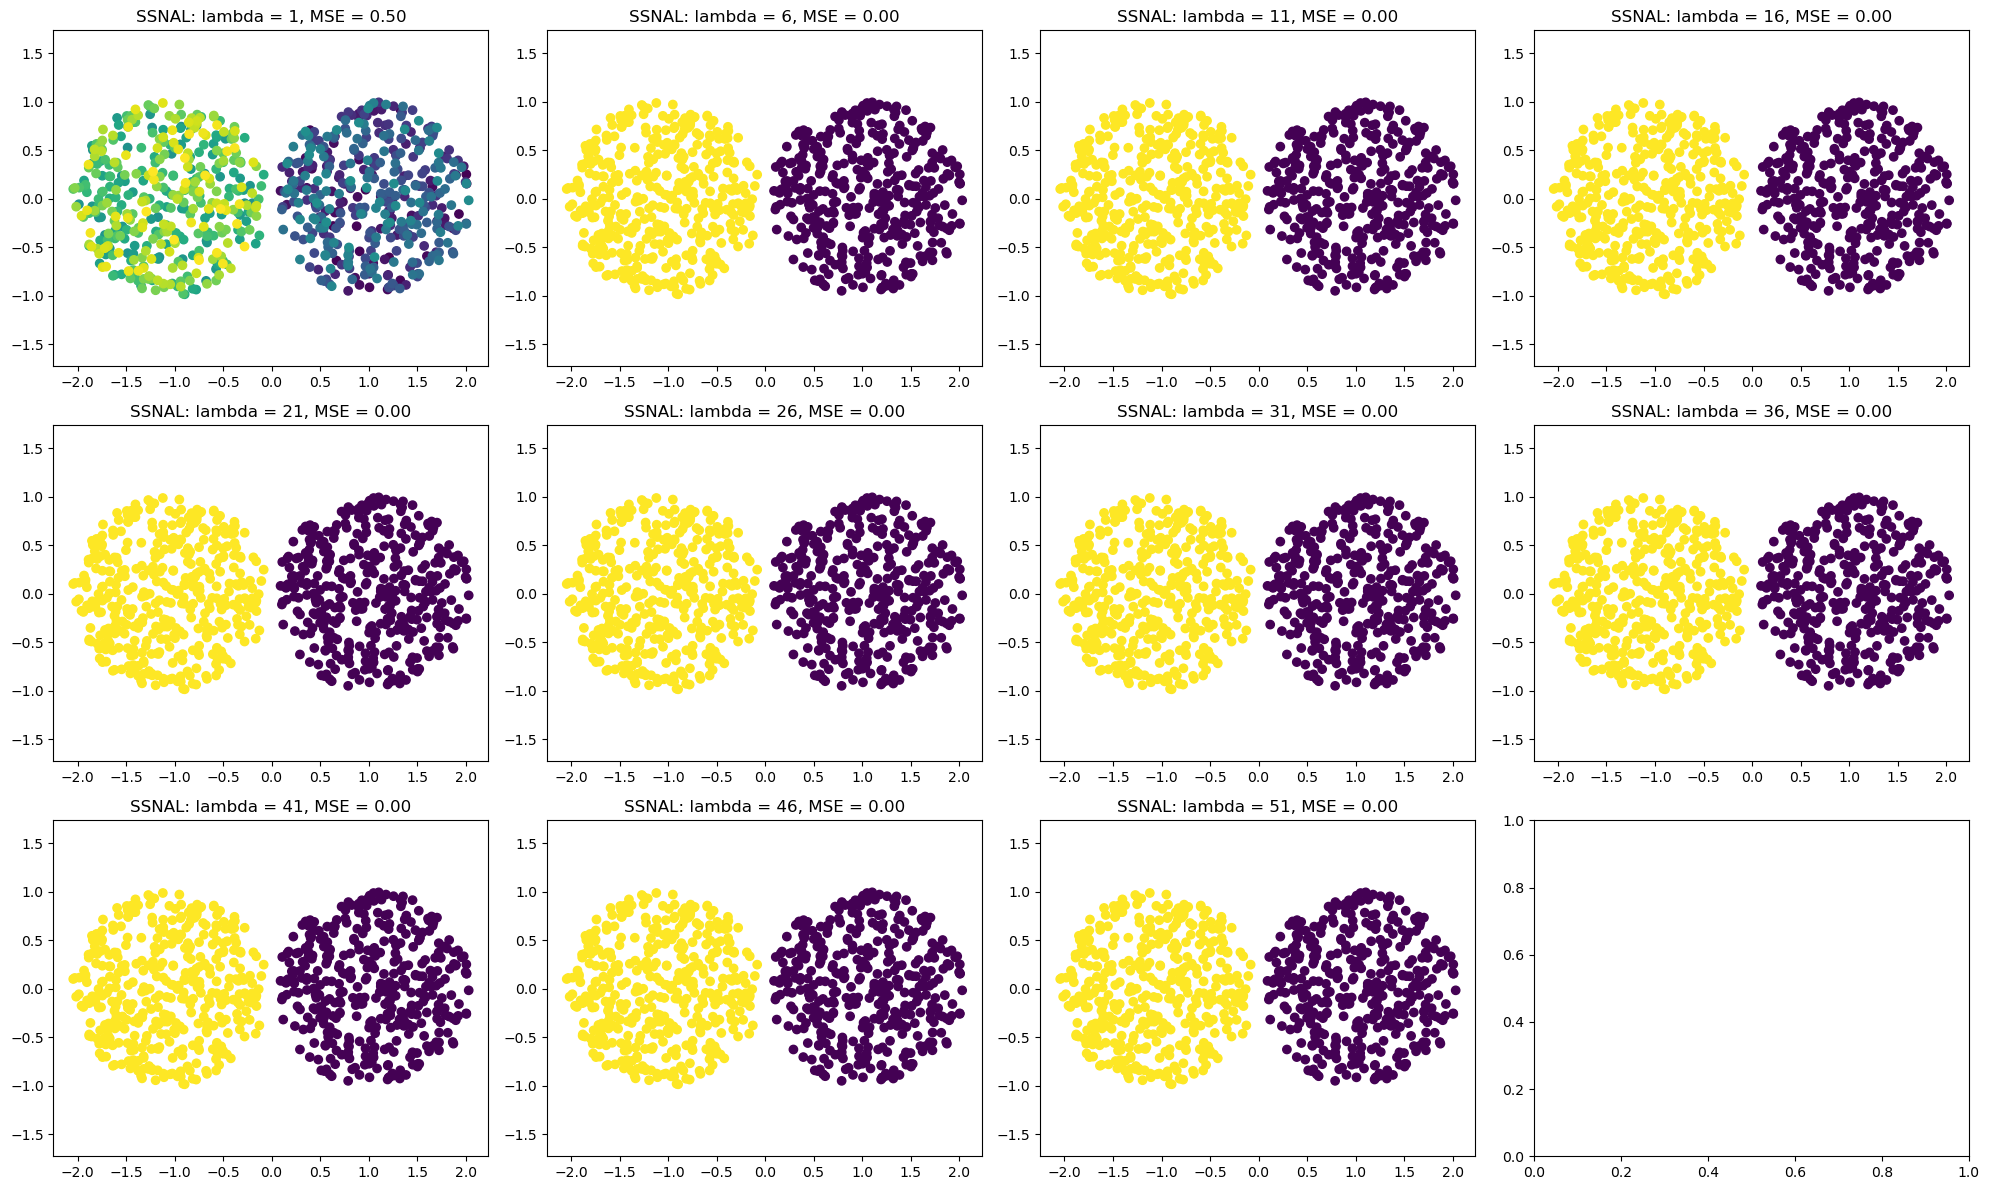

In [181]:
# Setting up the figure and axes for the subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 12))  # Adjust size as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop to create a scatter plot for each set of predictions
for i in range(11):
    ax = axes[i]
    sc = ax.scatter(X_ball[:, 0], X_ball[:, 1], c=predictions_low[i, :], cmap='viridis')
    ax.set_title(f"SSNAL: lambda = {lambdas[i]*2*N:.2g}, MSE = {mse_results_low[i]:.2f}")
    ax.axis('equal')

# Layout adjustment to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

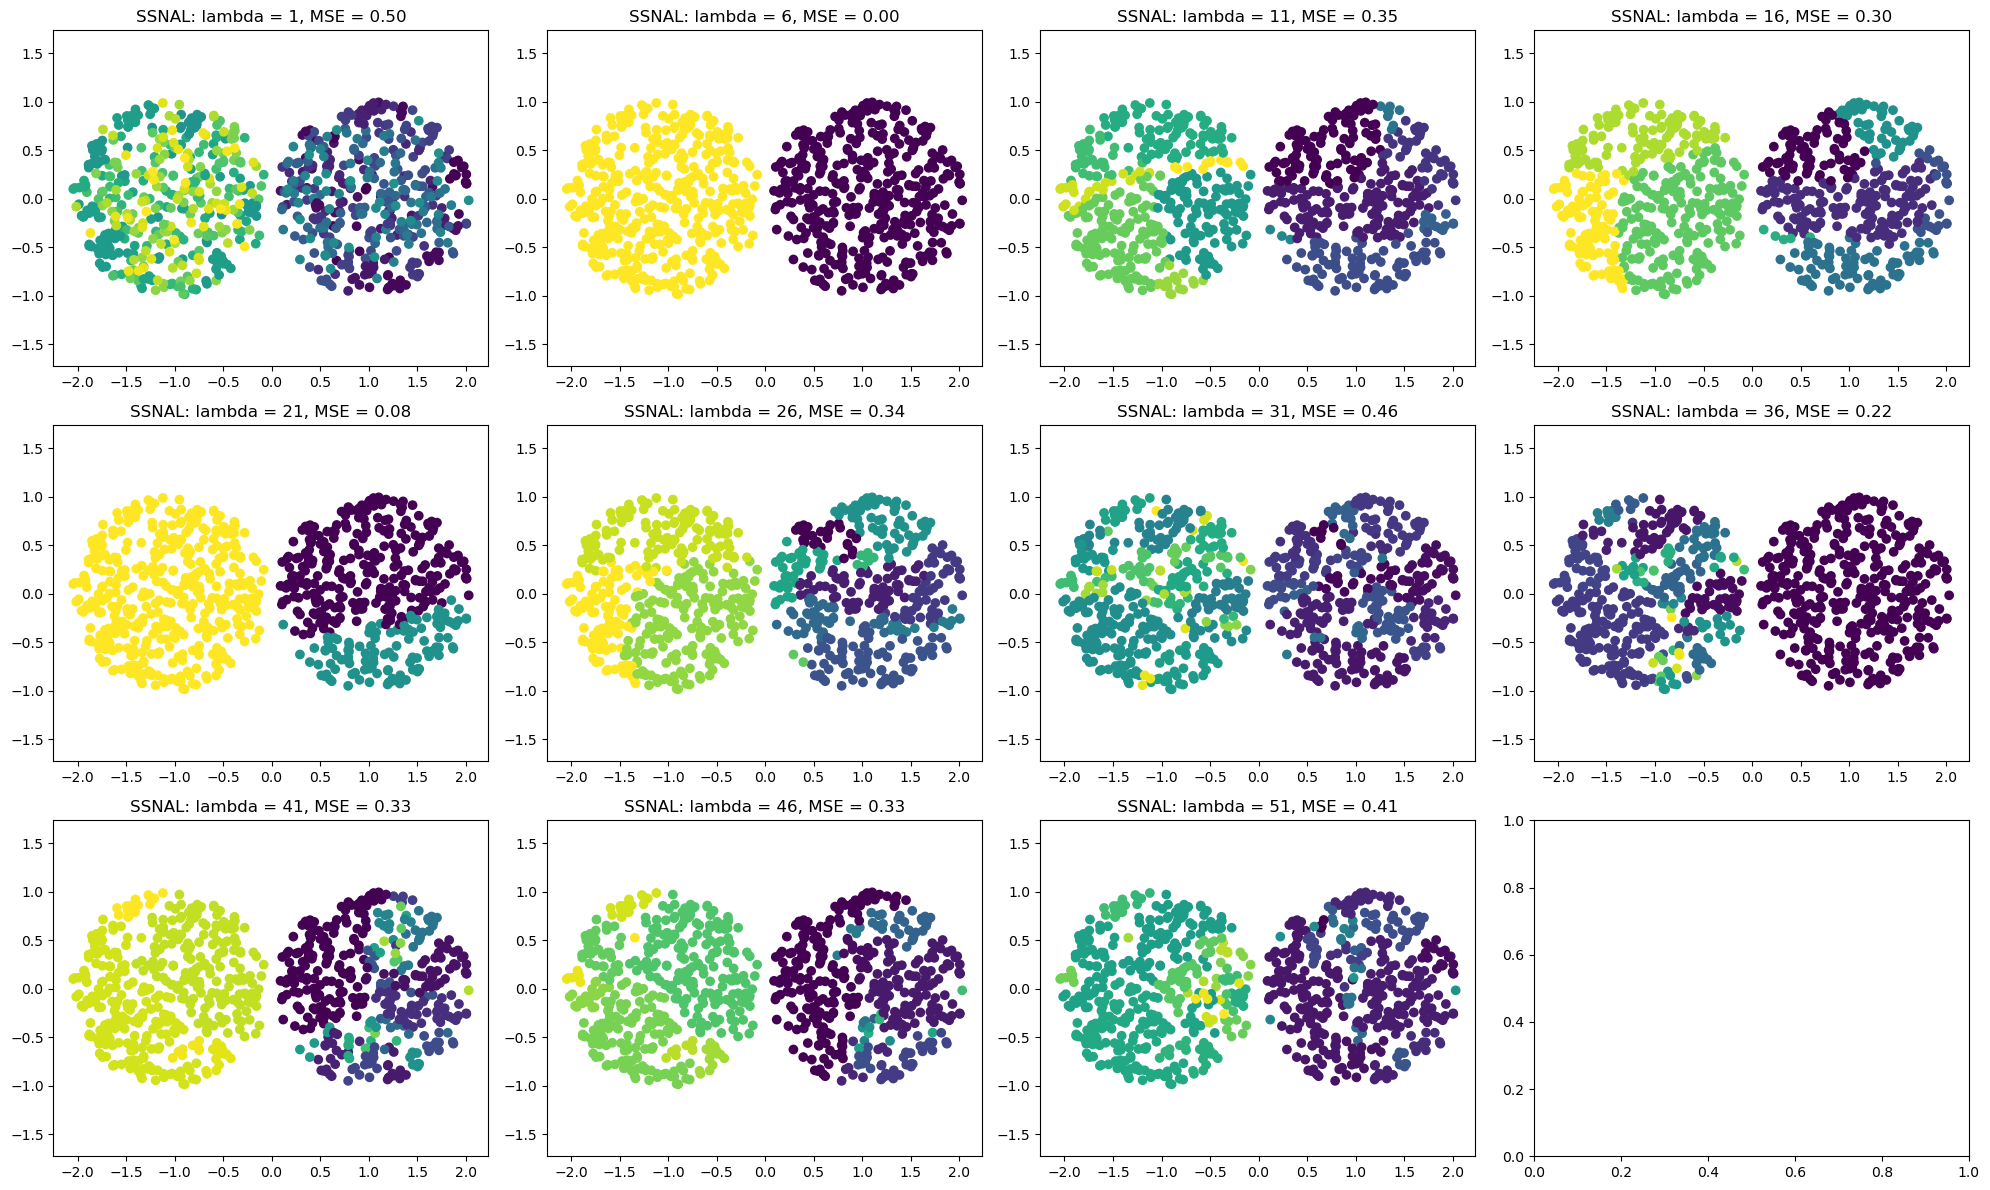

In [182]:
# Setting up the figure and axes for the subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 12))  # Adjust size as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop to create a scatter plot for each set of predictions
for i in range(11):
    ax = axes[i]
    sc = ax.scatter(X_ball[:, 0], X_ball[:, 1], c=predictions_high[i, :], cmap='viridis')
    ax.set_title(f"SSNAL: lambda = {lambdas[i]*2*N:.2g}, MSE = {mse_results_high[i]:.2f}")
    ax.axis('equal')

# Layout adjustment to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [276]:
gamma = 20
weight_matrix, _ = compute_weight_matrix(X_ball.T, gamma=gamma, omega=None)

lambd = 0.01
ssnal = pycvxcluster.pycvxcluster.SSNAL(k=X_ball.shape[0]-1, phi=gamma, gamma=lambd, maxiter=2000)
ssnal.fit(X=X_ball, save_labels=True, weight_matrix=weight_matrix,save_centers=True)
pred = np.array(ssnal.labels_) - 1
mse = mse_clusters(X_ball, y_ball, pred, centers_ball)
mse
plt.scatter(X_ball[:, 0], X_ball[:, 1], c=pred)

plt.title(f"SSNAL: lambda = {lambd}, MSE = {mse}")  # Title of the plot
plt.axis('equal')  # Equal aspect ratio

plt.show()

Computing weight matrix...


KeyboardInterrupt: 

In [247]:
# accurate gamma lambda correspondence

N = X_ball.shape[0]

lambdas = np.array([i for i in range(1, 52, 5)]) / (2 * N)
lambdas

gammas = (0.438691337650831 * (N**0.5 * (lambdas + 1.0) / np.log(N)**0.75)**(3/4))
mse_bounds = np.empty(len(lambdas), dtype=float)
mse_bounds_high = np.empty(len(lambdas), dtype=float)
mse_bounds_low = np.empty(len(lambdas), dtype=float)
mse_bounds_tenth = np.empty(len(lambdas), dtype=float)

lambdas = lambdas

for i, (lambd, gamma) in tqdm(enumerate(zip(lambdas, gammas)), total=len(lambdas)):
    mse_bounds[i] = centroid_bound(X_ball, gamma, lambd)
    mse_bounds_high[i] = centroid_bound(X_ball, gamma*2, lambd)
    mse_bounds_low[i] = centroid_bound(X_ball, gamma/2, lambd)
    mse_bounds_tenth[i] = centroid_bound(X_ball, gamma/10, lambd)

mse_bounds, mse_bounds_high, mse_bounds_low, mse_bounds_tenth, gammas

100%|██████████| 11/11 [00:00<00:00, 4035.45it/s]


(array([1.087021, 1.089567, 1.092110, 1.094651, 1.097190, 1.099727,
        1.102263, 1.104796, 1.107327, 1.109857, 1.112384]),
 array([1.190588, 1.193375, 1.196161, 1.198944, 1.201725, 1.204504,
        1.207281, 1.210056, 1.212828, 1.215599, 1.218367]),
 array([1.163049, 1.165772, 1.168493, 1.171212, 1.173928, 1.176643,
        1.179356, 1.182066, 1.184775, 1.187481, 1.190185]),
 array([1.783613, 1.787789, 1.791962, 1.796132, 1.800298, 1.804461,
        1.808621, 1.812778, 1.816932, 1.821082, 1.825229]),
 array([1.848911, 1.853240, 1.857565, 1.861888, 1.866207, 1.870522,
        1.874834, 1.879143, 1.883449, 1.887752, 1.892051]))

# N omega tradeoff

In [292]:
N_array = np.array([1000, 5000, 10000, 15000, 20000])

X_ball_list = []
y_ball_list = []
centers_ball_list = []
counts = np.zeros(len(N_array))
i=0
for N in N_array:
    X_ball, y_ball, centers_ball, _ = unit_balls(N, 2)
    X_ball_list.append(X_ball)
    y_ball_list.append(y_ball)
    centers_ball_list.append(centers_ball)
    counts[i] = X_ball.shape[0]
    i += 1

counts

array([772.000000, 3917.000000, 7828.000000, 11785.000000, 15719.000000])

In [293]:
lambd = 5
gammas = (0.438691337650831 * (counts**0.5 * (lambd + 1.0) / np.log(counts)**0.75)**(3/4))
lambdas = 5 / (2 * counts)
omegas = np.array([3, 0.4, 0.2, 0.13, 0.03])
gammas, lambdas

(array([7.011793, 11.400981, 14.127633, 16.061944, 17.592024]),
 array([0.003238, 0.000638, 0.000319, 0.000212, 0.000159]))

In [299]:
mse_results = np.empty(len(N_array), dtype=float)
predictions = []
cluster_times = np.empty(len(N_array), dtype=float)
cluster_iterations = np.empty(len(N_array), dtype=float)

for i, (X_ball, y_ball, center, lambd, gamma, omega) in tqdm(enumerate(zip(X_ball_list, y_ball_list, centers_ball_list, lambdas, gammas, omegas)), total=len(N_array)):
    start_time = time.perf_counter()
    weight_matrix, _ = compute_weight_matrix(X_ball.T, gamma=gamma, omega=omega, verbose=0)
    ssnal = pycvxcluster.pycvxcluster.SSNAL(k=X_ball.shape[0]-1, phi=gamma, gamma=lambd, maxiter=2000, verbose=0)
    ssnal.fit(X=X_ball, save_labels=True, weight_matrix=weight_matrix,save_centers=True)
    pred = np.array(ssnal.labels_) - 1
    mse = mse_clusters(X_ball, y_ball, pred, centers_ball)
    mse_results[i] = mse
    # Store the predictions in row i
    predictions.append(pred)
    cluster_iterations[i] = ssnal.iter_
    cluster_times[i] = time.perf_counter() - start_time

 80%|████████  | 4/5 [01:11<00:18, 18.15s/it]/Users/michaelthomas/Desktop/Semester 4/math466/Weighted SON Project/pycvxcluster-main/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
100%|██████████| 5/5 [01:22<00:00, 16.55s/it]


Computing weight matrix...
Weight matrix computed in 0.34021666552871466 seconds.


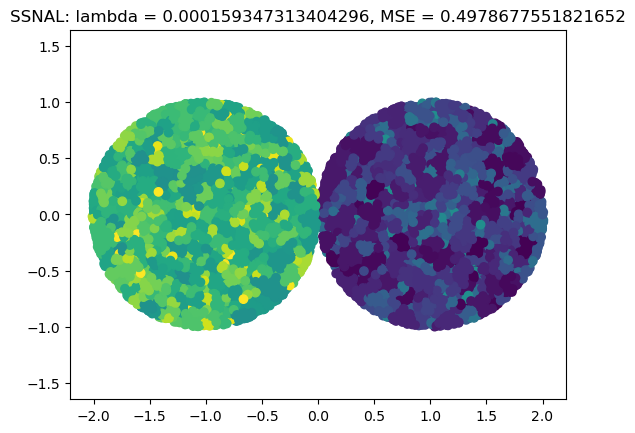

In [290]:
i=4
omega = 0.03
X_ball = X_ball_list[i]
y_ball = y_ball_list[i]
centers_ball = centers_ball_list[i]

gamma = gammas[i]
weight_matrix, _ = compute_weight_matrix(X_ball.T, gamma=gamma, omega=omega)

lambd = lambdas[i]
ssnal = pycvxcluster.pycvxcluster.SSNAL(k=X_ball.shape[0]-1, phi=gamma, gamma=lambd, maxiter=2000)
ssnal.fit(X=X_ball, save_labels=True, weight_matrix=weight_matrix,save_centers=True)
pred = np.array(ssnal.labels_) - 1
mse = mse_clusters(X_ball, y_ball, pred, centers_ball)
mse
plt.scatter(X_ball[:, 0], X_ball[:, 1], c=pred)

plt.title(f"SSNAL: lambda = {lambd}, MSE = {mse}")  # Title of the plot
plt.axis('equal')  # Equal aspect ratio

plt.show()

In [304]:
X_ball_list[i].shape, predictions[i].shape

((772, 2), (772,))

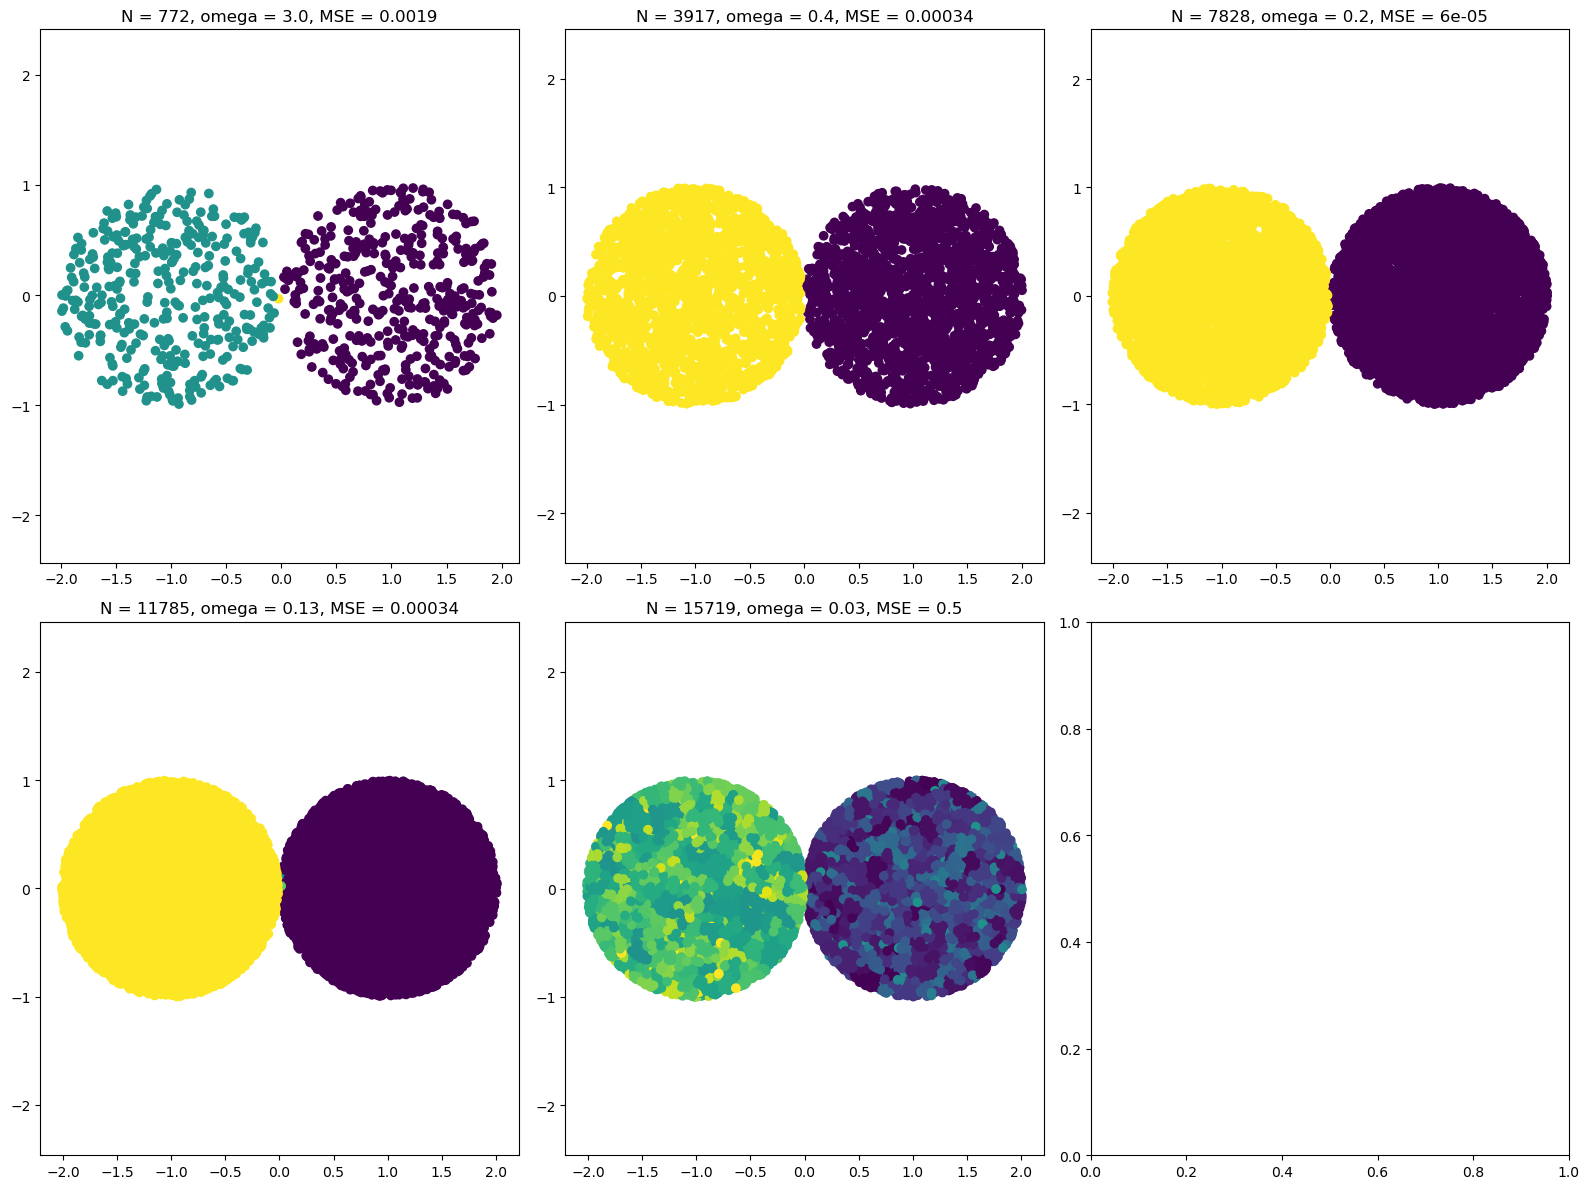

In [315]:
# Setting up the figure and axes for the subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 12))  # Adjust size as needed

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop to create a scatter plot for each set of predictions
for i in range(5):
    X_ball = X_ball_list[i]
    pred = predictions[i]
    ax = axes[i]
    sc = ax.scatter(X_ball[:, 0], X_ball[:, 1], c=pred, cmap='viridis')
    ax.set_title(f"N = {counts[i]:.0f}, omega = {omegas[i]}, MSE = {mse_results[i]:.2g}")
    #ax.figtext(f'time = {cluster_times[i]}, iter = {cluster_iterations[i]}')
    ax.axis('equal')

# Layout adjustment to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [320]:
# Organize data into a dictionary
data = {
    'omega': omegas,
    'N': counts,
    'mse': mse_results,
    'cluster time': cluster_times,
    'iterations': cluster_iterations
}

# Convert dictionary to DataFrame with transposition to flip rows and columns
omega_n_df = pd.DataFrame(data).transpose()

# Rename the columns if you want them labeled numerically or simply leave them as default
omega_n_df.columns = [1, 2, 3, 4, 5]

# Display the DataFrame
omega_n_df

1            2            3             4             5
omega           3.000000     0.400000     0.200000      0.130000      0.030000
N             772.000000  3917.000000  7828.000000  11785.000000  15719.000000
mse             0.001927     0.000338     0.000060      0.000341      0.498450
cluster time   18.121643    18.439540    14.921038     20.263697     11.021848
iterations      6.000000     4.000000     2.000000      5.000000     52.000000

In [321]:
omega_n_df.to_csv('omega_n_table.csv', index=True)

# Testing on shapes

## weighted son

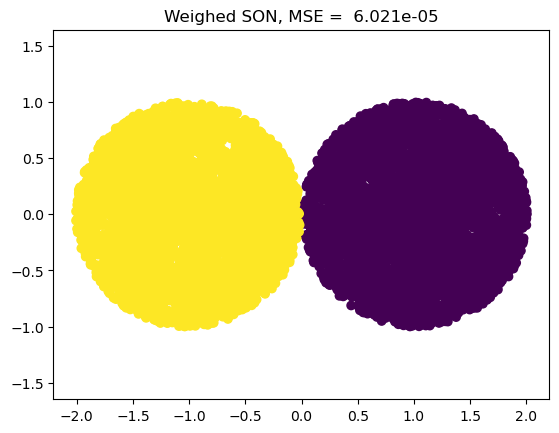

In [326]:
X_ball = X_ball_list[2]
pred = predictions[2]
mse = mse_results[2]

plt.scatter(X_ball[:, 0], X_ball[:, 1], c=pred)

plt.title(f"Weighed SON, MSE = {mse: .4g}")  # Title of the plot
plt.axis('equal')  # Equal aspect ratio

plt.show()

Computing weight matrix...
Weight matrix computed in 4.495729708112776 seconds.


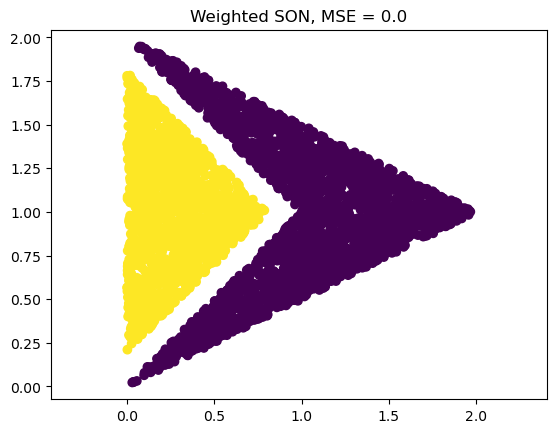

In [337]:
N = X_poly1.shape[0]
omega = 0.25
lambd = 0.005
gamma = (0.438691337650831 * (N**0.5 * (lambd*2*N + 1.0) / np.log(N)**0.75)**(3/4))
weight_matrix, _ = compute_weight_matrix(X_poly1.T, gamma=gamma, omega=omega)

ssnal = pycvxcluster.pycvxcluster.SSNAL(k=X_poly1.shape[0]-1, phi=gamma, gamma=lambd, maxiter=2000)
ssnal.fit(X=X_poly1, save_labels=True, weight_matrix=weight_matrix,save_centers=True)
pred = np.array(ssnal.labels_) - 1
mse = mse_clusters(X_poly1, y_poly1, pred, centers_poly1)
plt.scatter(X_poly1[:, 0], X_poly1[:, 1], c=pred)

plt.title(f"Weighted SON, MSE = {mse}")  # Title of the plot
plt.axis('equal')  # Equal aspect ratio

plt.show()

Computing weight matrix...
Weight matrix computed in 1.6593409590423107 seconds.


/Users/michaelthomas/Desktop/Semester 4/math466/Weighted SON Project/pycvxcluster-main/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/michaelthomas/Desktop/Semester 4/math466/Weighted SON Project/pycvxcluster-main/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


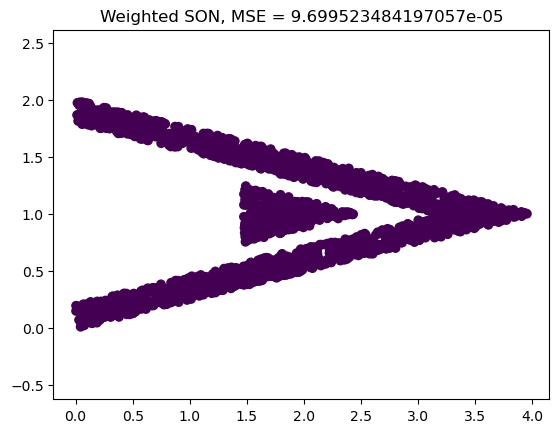

In [354]:
N = X_poly2.shape[0]
omega = 0.4
lambd = 0.005
gamma = (0.438691337650831 * (N**0.5 * (lambd*2*N + 1.0) / np.log(N)**0.75)**(3/4))
weight_matrix, _ = compute_weight_matrix(X_poly2.T, gamma=gamma, omega=omega)

ssnal = pycvxcluster.pycvxcluster.SSNAL(k=X_poly2.shape[0]-1, phi=gamma, gamma=lambd, maxiter=2000)
ssnal.fit(X=X_poly2, save_labels=True, weight_matrix=weight_matrix,save_centers=True)
pred = np.array(ssnal.labels_) - 1
mse = mse_clusters(X_poly2, y_poly2, pred, centers_poly2)
plt.scatter(X_poly2[:, 0], X_poly2[:, 1], c=pred)

plt.title(f"Weighted SON, MSE = {mse}")  # Title of the plot
plt.axis('equal')  # Equal aspect ratio

plt.show()

## unweighted son

In [323]:
X_ball, y_ball, centers_ball, d = unit_balls(1000, 2)

N, d = X_ball.shape
gamma = 1
weight_matrix = np.ones((X_ball.shape[0], X_ball.shape[0]))
for i in range(X_ball.shape[0]):
    weight_matrix[i,i] = 0

lambd = 0.003
ssnal = pycvxcluster.pycvxcluster.SSNAL(k=X_ball.shape[0]-1, phi=gamma, gamma=lambd, maxiter=2000)
ssnal.fit(X=X_ball, save_labels=True, weight_matrix=weight_matrix,save_centers=True)

/Users/michaelthomas/Desktop/Semester 4/math466/Weighted SON Project/pycvxcluster-main/pycvxcluster/algos/admm.py:32: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/michaelthomas/Desktop/Semester 4/math466/Weighted SON Project/pycvxcluster-main/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


SSNAL(gamma=0.003, k=739, maxiter=2000, phi=1)

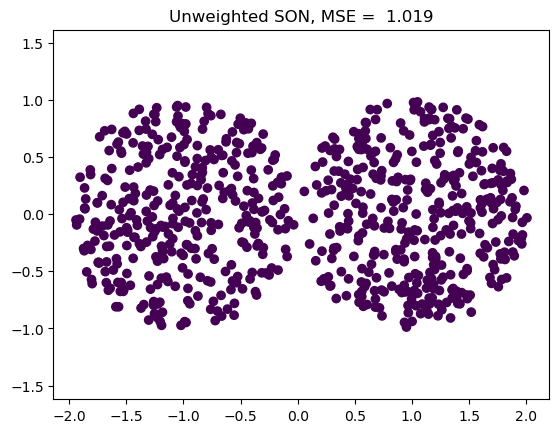

In [325]:
pred = np.array(ssnal.labels_) - 1
y_array = np.array(y_ball)
mse = mse_clusters(X_ball, y_array, pred, centers_ball)
plt.scatter(X_ball[:, 0], X_ball[:, 1], c=pred)

plt.title(f"Unweighted SON, MSE = {mse: .4g}")  # Title of the plot
plt.axis('equal')  # Equal aspect ratio

plt.show()

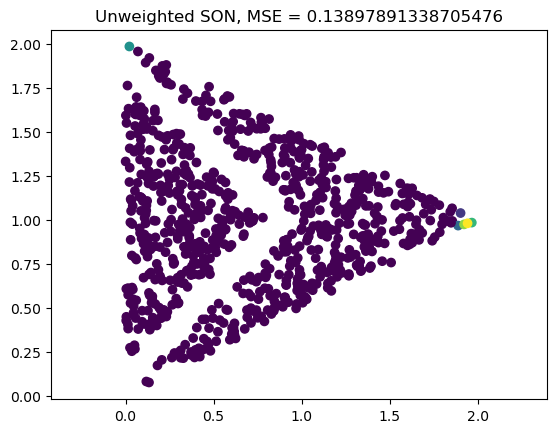

In [343]:
N, d = X_poly1.shape
lambd = 0.0015
omega = None
gamma = (0.438691337650831 * (N**0.5 * (lambd*2*N + 1.0) / np.log(N)**0.75)**(3/4))
weight_matrix = np.ones((N, N))
for i in range(N):
    weight_matrix[i,i] = 0

ssnal = pycvxcluster.pycvxcluster.SSNAL(k=N-1, phi=gamma, gamma=lambd, maxiter=2000)
ssnal.fit(X=X_poly1, save_labels=True, weight_matrix=weight_matrix,save_centers=True)

pred = np.array(ssnal.labels_) - 1
mse = mse_clusters(X_poly1, y_poly1, pred, centers_poly1)
plt.scatter(X_poly1[:, 0], X_poly1[:, 1], c=pred)

plt.title(f"Unweighted SON, MSE = {mse}")  # Title of the plot
plt.axis('equal')  # Equal aspect ratio

plt.show()

/Users/michaelthomas/Desktop/Semester 4/math466/Weighted SON Project/pycvxcluster-main/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


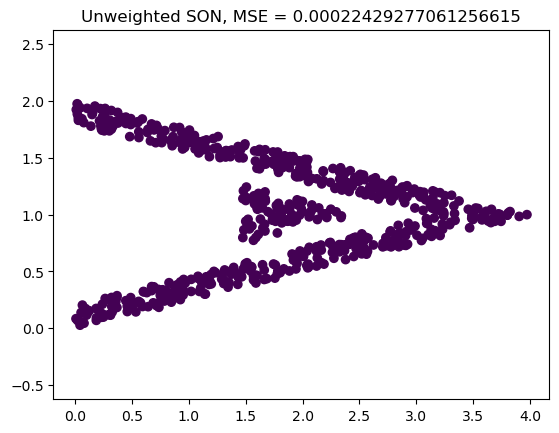

In [5]:
N, d = X_poly2.shape
lambd = 0.005
omega = None
gamma = (0.438691337650831 * (N**0.5 * (lambd*2*N + 1.0) / np.log(N)**0.75)**(3/4))
weight_matrix = np.ones((N, N))
for i in range(N):
    weight_matrix[i,i] = 0

ssnal = pycvxcluster.pycvxcluster.SSNAL(k=N-1, phi=gamma, gamma=lambd, maxiter=2000)
ssnal.fit(X=X_poly2, save_labels=True, weight_matrix=weight_matrix,save_centers=True)

pred = np.array(ssnal.labels_) - 1
mse = mse_clusters(X_poly2, y_poly2, pred, centers_poly2)
plt.scatter(X_poly2[:, 0], X_poly2[:, 1], c=pred)

plt.title(f"Unweighted SON, MSE = {mse}")  # Title of the plot
plt.axis('equal')  # Equal aspect ratio

plt.show()

## k-means++

/Users/michaelthomas/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


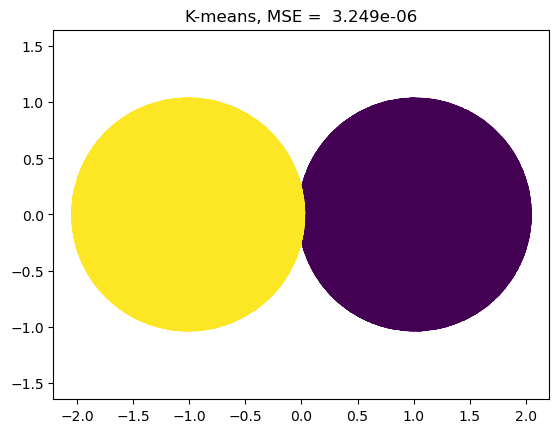

In [330]:
X_ball, y_ball, centers_ball, d = unit_balls(500000, 2)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2).fit(X_ball)
y_pred = kmeans.predict(X_ball)
plt.scatter(X_ball[:, 0], X_ball[:, 1], c=y_pred)
mse = mse_clusters(X_ball, y_ball, y_pred, centers_ball)

plt.title(f"K-means, MSE = {mse: .4g}")  # Title of the plot
plt.axis('equal')  # Equal aspect ratio

plt.show()

/Users/michaelthomas/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


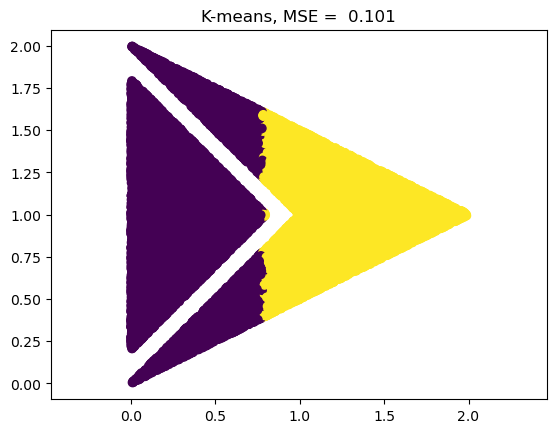

In [345]:
kmeans = KMeans(n_clusters=2).fit(X_poly1)
y_pred = kmeans.predict(X_poly1)
plt.scatter(X_poly1[:, 0], X_poly1[:, 1], c=y_pred)
mse = mse_clusters(X_poly1, y_poly1, y_pred, centers_poly1)

plt.title(f"K-means, MSE = {mse: .4g}")  # Title of the plot
plt.axis('equal')  # Equal aspect ratio

plt.show()

/Users/michaelthomas/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


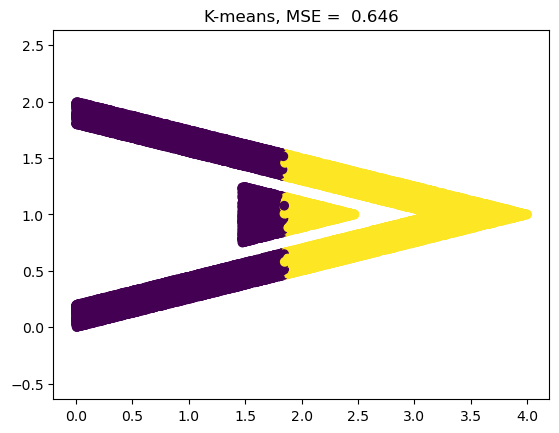

In [8]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2).fit(X_poly2)
y_pred = kmeans.predict(X_poly2)
plt.scatter(X_poly2[:, 0], X_poly2[:, 1], c=y_pred)
mse = mse_clusters(X_poly2, y_poly2, y_pred, centers_poly2)

plt.title(f"K-means, MSE = {mse: .4g}")  # Title of the plot
plt.axis('equal')  # Equal aspect ratio

plt.show()